# Исследование объявлений о продаже квартир

В моем распоряжении - данные сервиса Яндекс.Недвижимость, а именно, архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Я буду учиться определять рыночную стоимость объектов недвижимости. Моя задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

Мой основной инструмент — `pandas`. Я подключаю эту библиотеку. Также подключаю библиотеки `re`, `numpy`, `matplotlib` и `warnings` - они понадобятся для моих исследований.

Дополнительно отключу предупреждения.

In [1]:
import pandas as pd                # импорт библиотеки pandas
import re                          # импорт библиотеки регулярных выражений re
import numpy as np                 # импорт библиотеки numpy
import matplotlib.pyplot as plt    # импорт библиотеки matplotlib
import warnings as wg              # импорт библиотеки warnings

wg.filterwarnings('ignore')

Далее осуществляю чтение файла `real_estate_data.csv` из папки `/datasets` и сохраняю его в переменной `data`. Вывожу на экран первые пять строк таблицы.

In [2]:
# чтение файла с данными и сохранение в data в зависимости от его расположения
try:
    data = pd.read_csv('C:/Users/datasets/real_estate_data.csv')  # локальный путь
except:
    data = pd.read_csv('/datasets/real_estate_data.csv')          # серверный путь

print(data.head()) # получение первых 5 строк таблицы data

  total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0  20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...                                                                                                                                                                                                                                                                  
1  7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...                                                                                                                                                                                                                                                                  
2  10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...               

Данные склеены в одну строку вместо того, чтобы разбиться по колонкам. Нужно указать верный разделитель `\t`, как видно из таблицы выше:

In [3]:
try:
    data = pd.read_csv('C:/Users/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
print('Общая нформация об исходной таблице данных:')
print()
data.info() # получение общей информации о данных в таблице data

Общая нформация об исходной таблице данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest   

Для получения статистической информации о количественных данных использую метод `describe()` из библиотеки регулярных выражений `re`. Он поможет сразу увидеть некоторые проблемы в данных.
Для числовых переменных я оценю среднее, минимальное и максимальное значения, чтобы установить, в каком диапазоне лежат данные. Процентиль в данном случае не буду оценивать, поэтому список `percentiles` оставлю пустым. В список `include` я не буду включать категориальные переменные, а оставлю только `float` и `int`. Для наглядности округлю значения в таблице методом `round`.

In [5]:
include = ['float', 'int'] # какие типы включить
perc = [] # какие процентили включить

# сведения о значениях в столбцах
display(round(data.describe(percentiles = perc, include = include))) 

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.0,23699.0,23699.0,23699.0,14504.0,23613.0,21796.0,23699.0,21421.0,12180.0,18157.0,18180.0,18181.0,8079.0,18181.0,9110.0,20518.0
mean,10.0,6541549.0,60.0,2.0,3.0,11.0,34.0,6.0,11.0,1.0,28794.0,14191.0,1.0,491.0,1.0,518.0,181.0
std,6.0,10887013.0,36.0,1.0,1.0,7.0,22.0,5.0,6.0,1.0,12631.0,8608.0,1.0,342.0,1.0,278.0,220.0
min,0.0,12190.0,12.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0
50%,9.0,4650000.0,52.0,2.0,3.0,9.0,30.0,4.0,9.0,1.0,26726.0,13098.0,0.0,455.0,1.0,502.0,95.0
max,50.0,763000000.0,900.0,19.0,100.0,60.0,410.0,33.0,112.0,5.0,84869.0,65968.0,3.0,3190.0,3.0,1344.0,1580.0


Посмотрю описание остальных столбцов с оставшимися категориальными переменными `bool` и `object`.

In [6]:
display(data.describe(include = ['bool', 'object']))

,first_day_exposition,is_apartment,studio,open_plan,locality_name
count,23699,2775,23699,23699,23650
unique,1491,2,2,2,364
top,2018-02-01T00:00:00,False,False,False,Санкт-Петербург
freq,368,2725,23550,23632,15721


### Выводы по разделу

Итак, полученные данные, отформатированы отображены и предварительно пранализированы.

В таблице 22 столбца. Тип данных в столбцах — `bool`, `object`, `float`, `int`.

Согласно документации к данным:
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении


В названиях колонок обнаружено нарушения стиля (`cityCenters_nearest`, `parks_around3000` и `ponds_around3000`), количество значений в столбцах различается (значит, в данных есть пропущенные значения, требующие дополнительной предобработки), некоторые типы данных не соответствует логике, а именно, в колонках `first_day_exposition`, `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000` и `days_exposition`.  
Также на предварительном этапе бросаются в глаза выбросы (неприемлемо большие значения), которые могут нарушить статистику (например, 100 метров высота потолков, 5 лет висит объявление и пр.).

На этапе предобработки будет проведена оценка корректности данных по каждому столбцу, при необходимости, их исправление, замена типов данных (дата в формате текста и пр.) и обработка дубликатов при их наличии.

## Предобработка данных

Для начала восстановлю стиль названий для тех колонок, где я обнаружила нарушение, а именно составное имя переменной написано без знака подчёркивания - слитно и заглавные буквы:

In [7]:
# переименование столбцов
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 'parks_around3000': 'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'})
data.columns # проверка

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Обработка дубликатов

Для более качественной обработки пропущенных значений мне нужно привести в порядок значения в столбце `locality_name`. Применю метод `unique()` к столбцу для выявления неявных дубликатов.

In [8]:
print(data['locality_name'].unique())
print()
print('Всего уникальных значений в столбце -', len(data['locality_name'].unique()))

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

В первую очереь бросается в глаза написание слова полселок/посёлок. Исправлю и проверю, уникальных значений стало меньше или нет.

In [9]:
loc_unuique_before = len(data['locality_name'].unique())
data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
loc_unique_after = len(data['locality_name'].unique())
if loc_unuique_before == loc_unique_after:
    print('Количество уникальных значений не изменилось')
else:
    print('Количество уникальных значений уменьшилось на', loc_unuique_before - loc_unique_after, 'и теперь составляет', loc_unique_after)

Количество уникальных значений уменьшилось на 34 и теперь составляет 331


Теперь необходимо обработать обработать неявные дубликаты типа: `поселок Шушары / Шушары`. Для этого я принимаю решение оставить только наименования и исключить из названия следующие обозначения: деревня, поселок, поселок городского типа, котеджный поселок, садовое товарищество, посёлок Пансионат, городской посёлок, посёлок станции, село, посёлок при железнодорожной станции, садоводческое некоммерческое товарищество.

In [10]:
loc_unuique_before = len(data['locality_name'].unique())
replace_city = ['деревня ', 'поселок ', 'городского типа ', 'котеджный ', 'садовое товарищество ', 'Пансионат ', 'городской', 'станции ', 'село ', 'при железнодорожной ', 'садоводческое некоммерческое ']
data['locality_name_new'] = data['locality_name']
for element in replace_city:
    data['locality_name_new'] = data['locality_name_new'].str.replace(element, '')

data[['locality_name', 'locality_name_new']].drop_duplicates()
data['locality_name'] = data['locality_name_new']
data.drop(['locality_name_new'], axis = 1)
loc_unique_after = len(data['locality_name'].unique())

if loc_unuique_before == loc_unique_after:
    print('Количество уникальных значений не изменилось')
else:
    print('Количество уникальных значений уменьшилось на', loc_unuique_before - loc_unique_after, 'и теперь составляет', loc_unique_after)
print()
print(data['locality_name'].unique())

Количество уникальных значений уменьшилось на 16 и теперь составляет 315

['Санкт-Петербург' 'Шушары' ' Янино-1' 'Парголово' 'Мурино' 'Ломоносов'
 'Сертолово' 'Петергоф' 'Пушкин' 'Кудрово' 'Коммунар' 'Колпино'
 'Красный Бор' 'Гатчина' 'Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'Новое Девяткино' 'Металлострой' 'Лебяжье' 'Сиверский' 'Молодцово'
 'Кузьмоловский' 'Новая Ропша' 'Павловск' 'Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' 'Куттузи' 'Аннино'
 'Ефимовский' 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское'
 'Красное Село' 'Понтонный' 'Сясьстрой' 'Старая' 'Лесколово' 'Новый Свет'
 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры' 'Рощино' 'Кириши'
 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж' 'Копорье' 'Молодёжное'
 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно' 'Стрельна' 'Бокситогорск'
 'Александровская' 'Лопухинка' 'Пикалёво' 'Терволово' 'Советский'
 'Подпорожье' 'Петровск

Проверю количество явных дубликатов в датафрейме:

In [11]:
print('Количнство явных дубликатов в датафрейме -', data.duplicated().sum())

Количнство явных дубликатов в датафрейме - 0


### Обработка пропущенных значений

Определяю, в каких колонках исследуемой таблицы обнаружены пропуски:

In [12]:
# выявление колонок, содержащих пропуски; сортировка по убыванию количества пропусков
print(data.isna().sum().sort_values(ascending=False))

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
ponds_around_3000        5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
locality_name_new          49
first_day_exposition        0
last_price                  0
total_area                  0
open_plan                   0
rooms                       0
floor                       0
studio                      0
total_images                0
dtype: int64


Пропуски нельзя оставлять без внимания: группировка данных со значением `NaN` может привести к некорректным результатам анализа. 
На практике было бы правильно установить причину пропусков и восстановить данные. Но пока такой возможности нет, поэтому в целях сохранения параметров распределения заполняемых переменных, я буду последовательно проверять каждый стобец и, в зависимости от ситуации, обрабатывать строки с пропуском, если восстановить значение не удастся и количество заменяемых значений не повлияет на качество выборки.

#### Апартаменты ли (is_apartment)

Здесь доля пропусков составила:

In [13]:
print('Всего пропусков в столбце "is_apartment" -', data['is_apartment'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('is_apartment.isna()')) / len(data)))

Всего пропусков в столбце "is_apartment" - 20924
Доля пропущенных значений составляет 88.3%


In [14]:
print(data['is_apartment'].value_counts()) # как заполнен столбец
print()
# как распределены значения в заполненных ячеках
print('Доля апартаментов в выборке -', round(data.query('is_apartment == True')['is_apartment'].count() / data.query('is_apartment == False')['is_apartment'].count(), 2))

False    2725
True       50
Name: is_apartment, dtype: int64

Доля апартаментов в выборке - 0.02


Процент пропусков огромен. Если бы количество одного из значений было бы равно 0, то можно было бы предположить, в системе был сбой и заполнить пропуски недостающим булевым выражением, но здесь присутствуют оба выражения - `истина` и `ложь`, а доля апартаментов составляет 2%, попробую выбрать параметр, по которому выбрать, как заполнить пропущенные значения.
Проверю гипотезу зависимости появления пропусков от параметра `studio`.

In [15]:
print('Зависимость пропусков от того, студия или нет:')
if len(data.query('is_apartment  == True and studio == True')) == 0:
    print('не подтверждена')
else:
    print('подтверждена')
print()
print(data['studio'].value_counts())

Зависимость пропусков от того, студия или нет:
не подтверждена

False    23550
True       149
Name: studio, dtype: int64


Проверив все строки с заполненным значением `is_apartment`, убедилась, что зависимости судия/апартаменты нет, т.к. ни одна из студий, для которых известен параметр `is_apartment`, апартаментами не является. Ни один из параметров более не подходит для соответствия, скорее всего незаполненные значения - это квартиры, апартаментами не являющиеся, поэтому принимаю решение заполнить пропуски значением `False`. И проверю результаты замены.

In [16]:
data.loc[data['is_apartment'].isna(), 'is_apartment'] = False
print('Всего пропусков в столбце "is_apartment" -', data['is_apartment'].isna().sum())

Всего пропусков в столбце "is_apartment" - 0


#### Количество балконов (balcony)

In [17]:
print('Всего пропусков в столбце "balcony" -', data['balcony'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('balcony.isna()')) / len(data)))

Всего пропусков в столбце "balcony" - 11519
Доля пропущенных значений составляет 48.6%


На всякий случай проверю зависимость пропуска значений от, например, этажности здания, жилой или общей площади или количества комнат.

In [18]:
data['balcony_mis'] = data['balcony'].isna()

print('Проверка гипотезы о зависимости появления пропусков от этажности:')
print(round(data.groupby('floors_total')['balcony_mis'].mean(), 2).sort_values(ascending=False).head())
print()
print('Проверка гипотезы о зависимости появления пропусков от жилой площади:')
print(round(data.groupby('living_area')['balcony_mis'].mean(), 2).sort_values(ascending=False).head())
print()
print('Проверка гипотезы о зависимости появления пропусков от количества комнат:')
print(round(data.groupby('total_area')['balcony_mis'].mean(), 2).sort_values(ascending=False).head())
print()
print('Проверка гипотезы о зависимости появления пропусков от количества комнат:')
print(round(data.groupby('rooms')['balcony_mis'].mean(), 2).sort_values(ascending=False).head())

Проверка гипотезы о зависимости появления пропусков от этажности:
floors_total
60.0    1.00
34.0    1.00
37.0    1.00
52.0    1.00
1.0     0.96
Name: balcony_mis, dtype: float64

Проверка гипотезы о зависимости появления пропусков от жилой площади:
living_area
409.70    1.0
41.35     1.0
43.78     1.0
43.46     1.0
43.45     1.0
Name: balcony_mis, dtype: float64

Проверка гипотезы о зависимости появления пропусков от количества комнат:
total_area
900.00    1.0
73.72     1.0
73.05     1.0
71.75     1.0
69.75     1.0
Name: balcony_mis, dtype: float64

Проверка гипотезы о зависимости появления пропусков от количества комнат:
rooms
19    1.00
11    1.00
15    1.00
12    1.00
9     0.75
Name: balcony_mis, dtype: float64


Гипотезы о зависимости количества балконов от какого-либо из параметров не подтвердились, т.к. распределение долей в группах равномерно. В этом случае по логике пропущенные значения - это отсутствие балконов, поэтому я заменю пропущенные значения нулями. Проверю значения, чтобы уточнить, адекватна ли замена, и удостовериться, что в столбце не осталось пропущенных значений.

In [19]:
data.loc[data['balcony'].isna(), 'balcony'] = 0
print('Доля объектов недвижимости без балконов {:.1%}'.format(len(data.query('balcony == 0')) / len(data)))
print()
print('Всего пропусков в столбце "balcony" -', data['balcony'].isna().sum())

Доля объектов недвижимости без балконов 64.5%

Всего пропусков в столбце "balcony" - 0


#### Высота потолков (ceiling_height)

Посчитаю долю пропущенных значений в столбце `ceiling_height`.

In [20]:
print('Всего пропусков в столбце "ceiling_height" -', data['ceiling_height'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('ceiling_height.isna()')) / len(data)))

Всего пропусков в столбце "ceiling_height" - 9195
Доля пропущенных значений составляет 38.8%


Оценю данные в столбце:

In [21]:
data['ceiling_height'].value_counts().sort_values()

100.00       1
1.75         1
2.89         1
3.84         1
3.48         1
          ... 
2.80       993
3.00      1112
2.70      1574
2.60      1646
2.50      3515
Name: ceiling_height, Length: 183, dtype: int64

Для удобства работы с данными я округлю значения в столбце до десятых.

In [22]:
data['ceiling_height'] = round(data['ceiling_height'], 1)
#data['ceiling_height'].value_counts().sort_values()

Проверю зависимость пропуска значений высоты потолков от этажности зданий:

In [23]:
data['ceil_mis'] = data['ceiling_height'].isna()

print('Проверка гипотезы о зависимости появления пропусков от этажности:')
print(round(data.groupby('floors_total')['ceil_mis'].mean(), 2).sort_values(ascending=False).head())

Проверка гипотезы о зависимости появления пропусков от этажности:
floors_total
33.0    1.00
35.0    0.67
1.0     0.60
19.0    0.60
21.0    0.59
Name: ceil_mis, dtype: float64


Почти в 40% строк пропущено значение высоты потолков, удаление почти половины данных приведет к искажению статистики, поэтому пропуски нужно заполнить. единственный параметр, по которому я считаю адекватным посмотреть зависимость - это этажность дома. Гипотеза о зависимости появления пропусков от количества этажей в доме не подтвердилась. Исходя из здравого смысла, я буду заполнять пропуски медианным значением `median()` с группировкой по этажности.

Проверю наполнение столбца `floors_total` и если данные корректны - заполню недостающие данные.

In [24]:
#print(data['floors_total'].value_counts())
print('Высота потолков (в зависимости от этажности здания) заполняется следующими значениями:')
for floors_total in data['floors_total'].unique():
    median_ceil = data.loc[data['floors_total'] == floors_total, 'ceiling_height'].median()
    #print(floors_total , 'этажей в доме - проставляю высоту потолков - ', median_ceil)
    data.loc[(data['ceiling_height'].isna()) & (data['floors_total'] == floors_total), 'ceiling_height'] = median_ceil
    
print()
print('Всего пропусков в столбце "ceiling_height" -', data['ceiling_height'].isna().sum())

Высота потолков (в зависимости от этажности здания) заполняется следующими значениями:

Всего пропусков в столбце "ceiling_height" - 78


Для 33-этажной высотки проставлю высоту потолков 2.7 метра, как самое популярное значение. Где не указана этажность здания, проставлю медианное значение по всей выборки для того, чтобы в дальнейшем иметь возможность беспрепятсятвенно обрабатывать датафрейм.

In [25]:
data.loc[data['floors_total'] == 33, 'ceiling_height'] = 2.7
print()
#print('Всего пропусков в столбце "ceiling_height" -', data['ceiling_height'].isna().sum())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print('Всего пропусков в столбце "ceiling_height" -', data['ceiling_height'].isna().sum())


Всего пропусков в столбце "ceiling_height" - 0


#### Расположение объекта рядом с... 

В этом разделе я буду рассматривать столбцы `airports_nearest`, `city_centers_nearest`, `ponds_around_3000`, `parks_around_3000` `parks_nearest` и `ponds_nearest`. В этих шести столбцах речь идет о расположении объекта, поэтому привязку буду делать по столбцу `locality_name`. 

Начну анализ со столбцов `parks_nearest` и `ponds_nearest`. Здесь процент пропусков больше.

In [26]:
places = ['airports_nearest', 'city_centers_nearest', 'ponds_around_3000', 'parks_around_3000', 'parks_nearest', 'ponds_nearest']
print('Всего пропусков в столбце "parks_nearest" -', data['parks_nearest'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('parks_nearest.isna()')) / len(data)))
print()
print('Всего пропусков в столбце "ponds_nearest" -', data['ponds_nearest'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('ponds_nearest.isna()')) / len(data)))

Всего пропусков в столбце "parks_nearest" - 15620
Доля пропущенных значений составляет 65.9%

Всего пропусков в столбце "ponds_nearest" - 14589
Доля пропущенных значений составляет 61.6%


Почти две трети данных не содержат информацию о том, на каком удалении от объекта находится ближайший парк и водоем. Я попробую заполнить недостающие значения средними значениями этого параметра в районе, в котором находится объект. 

In [27]:
#Расстояние до ближайшего парка/пруда (в зависимости от района)
for location in data['locality_name'].unique():
    parks_mean = data.loc[data['locality_name'] == location, 'parks_nearest'].mean()
    ponds_mean = data.loc[data['locality_name'] == location, 'ponds_nearest'].mean()
    data.loc[(data['parks_nearest'].isna()) & (data['locality_name'] == location), 'parks_nearest'] = parks_mean
    data.loc[(data['ponds_nearest'].isna()) & (data['locality_name'] == location), 'ponds_nearest'] = ponds_mean

print('Всего пропусков в столбце "parks_nearest" -', data['parks_nearest'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data[data['parks_nearest'].isna()]) / len(data)))
print()
print('Всего пропусков в столбце "ponds_nearest" -', data['ponds_nearest'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data[data['ponds_nearest'].isna()]) / len(data)))

Всего пропусков в столбце "parks_nearest" - 6032
Доля пропущенных значений составляет 25.5%

Всего пропусков в столбце "ponds_nearest" - 4962
Доля пропущенных значений составляет 20.9%


Количество пропущенных значений уменьшилось втрое, теперь количество пропусков соизмеримо с пропущенными значениями во всех колонках, касающихся расположения объектов недвижимости рядом с  парками, водоемами, аэропортом и центром города: 

In [28]:
print(data[places].isna().sum().sort_values(ascending=False))

parks_nearest           6032
airports_nearest        5542
city_centers_nearest    5519
parks_around_3000       5518
ponds_around_3000       5518
ponds_nearest           4962
dtype: int64


In [29]:
#print(data.isna().sum().sort_values(ascending=False))

Рассмотрю для начала пару столбцов `ponds_around_3000` и `parks_around_3000`. В этих столбцах одинаковое количество пропущенных значений (5518). Проверю, соответствуют ли они друг другу.

In [30]:
parks_nan = len(data[data['parks_around_3000'].isna()])
ponds_nan = data.query('parks_around_3000.isna()')['ponds_around_3000'].isna().count()
if parks_nan == ponds_nan and ponds_nan:
    print('Полное соответствие')
else:
    print('Не соответствуют')
print()    
print('Всего пропусков в столбцах -', data['parks_around_3000'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('parks_around_3000.isna()')) / len(data)))

Полное соответствие

Всего пропусков в столбцах - 5518
Доля пропущенных значений составляет 23.3%


Проверка показала, что пропуски в этих столбцах полностью соответствуют друг другу и составляют чуть меньше четверти от всех данных. Необходимо выяснить, от чего зависит появление этих пропусков и как их заполнять.

Хочу проверить гипотезу о том, добавилась ли опция указания этих сведений (или была удалена), например, недавно. Проверю зависимость пропусков от столбца `first_day_exposition`. Для этого необходимо привести столбец в числовой формат, используя метод `to_datetime()`.

In [31]:
#print(data['first_day_exposition'])
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#print(data['first_day_exposition'].value_counts())

print(data[['first_day_exposition', 'parks_around_3000']].sort_values(by='first_day_exposition').head(30))
print()
print(data[['first_day_exposition', 'parks_around_3000']].sort_values(by='first_day_exposition').tail(10))

      first_day_exposition  parks_around_3000
10132           2014-11-27                0.0
8393            2014-11-27                1.0
15857           2014-11-27                0.0
2831            2014-11-27                1.0
696             2014-11-27                0.0
3486            2014-11-27                1.0
21867           2014-11-27                1.0
6726            2014-11-27                1.0
16159           2014-11-27                1.0
20635           2014-11-27                0.0
13246           2014-11-27                1.0
15427           2014-11-27                1.0
3873            2014-11-27                1.0
4812            2014-11-27                1.0
3955            2014-11-27                1.0
7027            2014-11-27                1.0
617             2014-11-27                1.0
3291            2014-11-27                1.0
10364           2014-11-27                1.0
19352           2014-11-29                0.0
15550           2014-12-04        

Гипотеза о том, что опция занесения информации о парках и водоемах рядом с объектом недвижимости появилась недавно (или недавно удалена) - не подтверждена, т.к. и 2014 и в 2019 годах пропуски присутствуют и они расположены не подряд.

Выведу на экран строки с пропущенными значениями, чтобы визуально оценить четверть дарафрейма с прорпущенными значениями, а также список уникальных местоположений, где значения не пропущены/пропущены.

In [32]:
display(data.query('ponds_around_3000.isna()')[['airports_nearest', 'city_centers_nearest', 'parks_around_3000', 'parks_nearest', 'ponds_around_3000', 'ponds_nearest']].head(30))
#print()
print('Населенные пункты, где значения НЕ ПРОПУЩЕНЫ - всего', len(data[~data['parks_nearest'].isna()]['locality_name'].unique()), 'населенных пунктов')
print(data[~data['parks_nearest'].isna()]['locality_name'].unique())
print()
print('Населенные пункты, где значения ПРОПУЩЕНЫ - всего', len(data[data['parks_nearest'].isna()]['locality_name'].unique()), 'населенных пунктов')
print(data[data['parks_nearest'].isna()]['locality_name'].unique())

,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest
5,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,133.000000
12,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,133.000000
47,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,133.000000
62,NaN,NaN,NaN,NaN,NaN,NaN


Населенные пункты, где значения НЕ ПРОПУЩЕНЫ - всего 13 населенных пунктов
['Санкт-Петербург' 'Парголово' 'Ломоносов' 'Петергоф' 'Пушкин' 'Колпино'
 'Кронштадт' 'Павловск' 'Сестрорецк' 'Красное Село' 'Зеленогорск'
 'Стрельна' nan]

Населенные пункты, где значения ПРОПУЩЕНЫ - всего 303 населенных пунктов
['Шушары' ' Янино-1' 'Мурино' 'Сертолово' 'Кудрово' 'Коммунар'
 'Красный Бор' 'Гатчина' 'Фёдоровское' 'Выборг' 'Кировск'
 'Новое Девяткино' 'Металлострой' 'Лебяжье' 'Сиверский' 'Молодцово'
 'Кузьмоловский' 'Новая Ропша' 'Пикколово' 'Всеволожск' 'Волхов'
 'Кингисепп' 'Приозерск' 'Куттузи' 'Аннино' 'Ефимовский' 'Плодовое'
 'Заклинье' 'Торковичи' 'Первомайское' 'Понтонный' 'Сясьстрой' 'Старая'
 'Лесколово' 'Новый Свет' 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург'
 'Никольское' 'Сосновый Бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры'
 'Рощино' 'Кириши' 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж'
 'Копорье' 'Молодёжное' 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно'
 'Бокситогорск' 'Алекса

Даже визуально можно определить, что пропуски в исследуемых шести ячейках в основном соответствуют друг другу. Также мною определено, что населенные пункты, в которых проставлены значения (это 76.7% всех данных) - это 13 городов и крупных поселков, а строки с отсутствующими значениями - их 319 (составляет 23.3% от всех данных) - это маленькие поселки и деревни. Для каждого поселения определять по 6 параметров (рассотяение до ближайшего парка, водоема и т.д.) не представляется возможным, поэтому в целях сохранения репрезентативности выборки мне придется исключить из датафрейма строки, в которых присутствуют пропуски. Предварительно заполню оставшиеся 4 столбца медианными значенями по местоположению. 
Проверю полученные данные.

In [33]:
for location in data['locality_name'].unique():
    city_mean = data.loc[data['locality_name'] == location, 'city_centers_nearest'].mean()
    aerp_mean = data.loc[data['locality_name'] == location, 'airports_nearest'].mean()
    parks_3000 = data.loc[data['locality_name'] == location, 'parks_around_3000'].mean()
    ponds_3000 = data.loc[data['locality_name'] == location, 'ponds_around_3000'].mean()
    data.loc[(data['city_centers_nearest'].isna()) & (data['locality_name'] == location), 'city_centers_nearest'] = city_mean
    data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == location), 'airports_nearest'] = aerp_mean
    data.loc[(data['parks_around_3000'].isna()) & (data['locality_name'] == location), 'parks_around_3000'] = parks_3000
    data.loc[(data['ponds_around_3000'].isna()) & (data['locality_name'] == location), 'ponds_around_3000'] = ponds_3000
    
data = data[~(data['parks_nearest'].isna()) &
            ~(data['ponds_nearest'].isna()) & 
            ~(data['city_centers_nearest'].isna()) & 
            ~(data['airports_nearest'].isna()) & 
            ~(data['parks_around_3000'].isna()) &
            ~(data['ponds_around_3000'].isna())]
data = data.reset_index(drop=True)    
    
#print(data.isna().sum().sort_values(ascending=False))

#### Этажность строения

In [34]:
print('Всего пропусков в столбце "floors_total" -', data['floors_total'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('floors_total.isna()')) / len(data)))

Всего пропусков в столбце "floors_total" - 73
Доля пропущенных значений составляет 0.4%


Менее полпроцента пропусков. Посмотрю эти данные. Предположу, что в зависимости от района этажность разнится, проверю свое предположение и заполню пропущенные значения в зависимости от локации медианным значением с проверкой, на каком этаже продается квартира и если условие не выполняется, то проставлю в качестве этажности дома значение этажа, на котором расположен продаваемый объект недвижимости.

In [35]:
#display(data[data['floors_total'].isna()])
#print()

for location in data['locality_name'].unique():
    median_floor = data.loc[data['locality_name'] == location, 'floors_total'].median()
    data.loc[(data['floors_total'].isna())
             & (data['locality_name'] == location)
             & (data['floor'] <= median_ceil), 'floors_total'] = median_ceil
    data.loc[(data['floors_total'].isna())
             & (data['locality_name'] == location)
             & (data['floor'] > median_ceil), 'floors_total'] = data['floor']
print()
print('Всего пропусков в столбце "ceiling_height" -', data['ceiling_height'].isna().sum())


Всего пропусков в столбце "ceiling_height" - 0


Проверка, соответствия этажа, на котором находится объект недвижимости, этажности строения:

In [36]:
error_floor = data.query('floor > floors_total')
print('Количество несоответствий в этажности -', len(error_floor))
print('{:.1%} от общего числа записей'.format((len(error_floor)) / len(data)))

Количество несоответствий в этажности - 0
0.0% от общего числа записей


Хорошо, что ошибок не найдено!

#### Площади (кухня, жилая, общая)

In [37]:
print('Всего пропусков в столбце "kitchen_area" -', data['kitchen_area'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('kitchen_area.isna()')) / len(data)))
print()
print('Всего пропусков в столбце "living_area" -', data['living_area'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('living_area.isna()')) / len(data)))

Всего пропусков в столбце "kitchen_area" - 1520
Доля пропущенных значений составляет 8.6%

Всего пропусков в столбце "living_area" - 1242
Доля пропущенных значений составляет 7.0%


Не более 10% пропущенных значений в столбцах. Т.к. значение общей площади квартир указано во всех случаях, то попробую применить категоризацию и заполнить пропуски медианным значением по общему параметру: 

In [38]:
print(round(data['total_area'].describe(), 1))

count    17661.0
mean        63.7
std         39.4
min         12.0
25%         41.3
50%         54.3
75%         73.5
max        900.0
Name: total_area, dtype: float64


Исходя из этого, применю следующие категории для значений общей площади:
* меньше 20 кв.м. - маленькая площадь;
* от 20 кв.м. до 50 кв.м. включительно - средняя площадь;
* от 51 кв.м. до 65 кв.м. включительно - большая площадь;
* больше 66 кв.м. - очень большая.

In [39]:
# определение категории в соответствии с площадью
def categorize(total_area):
    if total_area < 30:
        return 'маленьная'
    if 30 <= total_area < 50:
        return 'средняя'
    if 50 <= total_area < 65:
        return 'большая'
    if total_area >= 65:
        return 'очень большая'

data['total_area_category'] = data['total_area'].apply(categorize) # запись категории дохода в столбец

print('Количество записей в категориях:')
print(data['total_area_category'].value_counts())
print()
print('Доля в % от всех записей:')
print(round(data['total_area_category'].value_counts() / len(data) * 100))

Количество записей в категориях:
средняя          7184
очень большая    6004
большая          4063
маленьная         410
Name: total_area_category, dtype: int64

Доля в % от всех записей:
средняя          41.0
очень большая    34.0
большая          23.0
маленьная         2.0
Name: total_area_category, dtype: float64


Теперь на основании данных этих категорий проставлю значения жилой площади и площади кухни, проведу проверку, не превышают ли значения в столбцах `kitchen_area` и `living_area` общую площадь квартиры.

In [40]:
for total_area in data['total_area_category'].unique():
    kitchen_median = data.loc[data['total_area_category'] == total_area, 'kitchen_area'].median()
    living_median = data.loc[data['total_area_category'] == total_area, 'living_area'].median()
    data.loc[(data['kitchen_area'].isna()) & (data['total_area_category'] == total_area), 'kitchen_area'] = kitchen_median
    data.loc[(data['living_area'].isna()) & (data['total_area_category'] == total_area), 'living_area'] = living_median

error_area = data.query('kitchen_area > total_area & living_area > total_area')
print('Количество несоответствий в площади -', len(error_area))
print('{:.1%} от общего числа записей'.format((len(error_area)) / len(data)))

Количество несоответствий в площади - 0
0.0% от общего числа записей


#### Дни размещения

In [41]:
print('Всего пропусков в столбце "days_exposition" -', data['days_exposition'].isna().sum())
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('days_exposition.isna()')) / len(data)))

Всего пропусков в столбце "days_exposition" - 2309
Доля пропущенных значений составляет 13.1%


Заполню данный столбец медианным значением по всем данным, сделав проверку, чтобы выбранное количество дней не превышало количество дней с момента размещения до текущей даты.

In [42]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())
#print(data[['days_exposition', 'first_day_exposition']])

In [43]:
data['days_exposition'] = data['days_exposition'].astype('int')
data['data'] = pd.to_datetime(data['first_day_exposition']) + pd.to_timedelta(pd.np.ceil(data['days_exposition']), unit="D")

current_date = '2022-01-01 00:00:00'
error_data = data.query('data > @current_date')
print('Количество несоответствий даты -', len(error_data))
print('{:.1%} от общего числа записей'.format((len(error_data)) / len(data)))


Количество несоответствий даты - 0
0.0% от общего числа записей


#### Местоположение объекта

9 пропусков в столбце `locality_name` заполнить не удастся, поэтому исключу эти строки из датафрейма. Обновлю индексы.

In [44]:
data = data[~(data['locality_name'].isna())]
data = data.reset_index(drop=True)

Проверю, не осталось ли пропущенных значений в датафрейме, предварительно удалив дополнительные столбцы:

In [45]:
data = data.drop(['balcony_mis', 'ceil_mis', 'data'], axis = 1)
print(data.isna().sum())

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
city_centers_nearest    0
parks_around_3000       0
parks_nearest           0
ponds_around_3000       0
ponds_nearest           0
days_exposition         0
locality_name_new       0
total_area_category     0
dtype: int64


### Изменение типов данных

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17652 entries, 0 to 17651
Data columns (total 24 columns):
total_images            17652 non-null int64
last_price              17652 non-null float64
total_area              17652 non-null float64
first_day_exposition    17652 non-null datetime64[ns]
rooms                   17652 non-null int64
ceiling_height          17652 non-null float64
floors_total            17652 non-null float64
living_area             17652 non-null float64
floor                   17652 non-null int64
is_apartment            17652 non-null bool
studio                  17652 non-null bool
open_plan               17652 non-null bool
kitchen_area            17652 non-null float64
balcony                 17652 non-null float64
locality_name           17652 non-null object
airports_nearest        17652 non-null float64
city_centers_nearest    17652 non-null float64
parks_around_3000       17652 non-null float64
parks_nearest           17652 non-null float64
ponds_a

 В некоторвых колонках датафрейма я обнаружила несоответствие типов данных, а именно:
`floors_total` (количество этажей), `balcony` (количество балконов), `parks_around_3000` (число парков в радиусе 3 км), `ponds_around_3000` (число водоёмов в радиусе 3 км) - все эти значения должны быть целочисленнымы (в датафрейме - тип `float`). Также я хочу заменить на целочисленные значения столбец `last_price`, т.к. учет копейки при покупке/продаже квартир считаю нецелесообпазным. Проведу замену типов:

In [47]:
type_change = ['floors_total', 'balcony', 'parks_around_3000', 'ponds_around_3000', 'last_price']

for element in type_change:
    print('Исходный тип данных в столбце', element, '-', data[element].dtypes)
    data[element] = data[element].astype('int')
    print('Тип данных в столбце', element, '-', data[element].dtypes)
    print()

Исходный тип данных в столбце floors_total - float64
Тип данных в столбце floors_total - int64

Исходный тип данных в столбце balcony - float64
Тип данных в столбце balcony - int64

Исходный тип данных в столбце parks_around_3000 - float64
Тип данных в столбце parks_around_3000 - int64

Исходный тип данных в столбце ponds_around_3000 - float64
Тип данных в столбце ponds_around_3000 - int64

Исходный тип данных в столбце last_price - float64
Тип данных в столбце last_price - int64



### Выводы по разделу

В результате проведенной предобработки данных были проведены следующие мероприятия:
* восстановлен стиль названий для колонок с нарушениями стиля;
* обработаны все дубликаты в столбце `locality_name`. Названия населенных пунктов приведены к единообразному виду;
* обработаны все пропуски во всех столбцах. Везде, где представилась возможность, пропуски заполнены в соответствии со следующей логикой:
     - булевы отсутствия заполнены значением `False`;
     - пропуски, связанные с местоположением объекта (количество парков рядом, водоемов, близость к центру, аэродрому и пр. заполнены медианными значениями по параметру `locality_name`. Те строки, для которых не удалось установить принадлежность к местоположению (у которых отсутствует этот параметр) были исключены из датафрейма;
     - отсутствующие значения в столбце `balcony` были заменены нулями в связи с тем, что не была найдена связь с параметрами, присутствующими в таблице;
     - в качестве высоты потолков была проставлена медиана в соответствии с этажностью строения, но не выше, чем этаж, указанный в объявлении;
     - отстутствующие значения площади кухни и жилой площади были заменены медианным значением с использованием параметра общей площади квартиры `total_area`;
     - пропуски в колоке `days_exposition` заменены медианным значением по всем данным с проверкой, чтобы проставляемое количество дней не превышало количество дней с момента размещения до текущей даты (01.01.2022);
     - пропуски в столбце `locality_name` заполнить не удалось, поэтому строки с отсутствующим значением местоположения объекта были исключены из датафрейма.
* в соответствии с логикой и здравым смыслом была произведена замена типов в столбцах `количество этажей`, `количество балконов`, `число парков в радиусе 3 км`, `число водоёмов в радиусе 3 км` , `конечная стоимость квартиры` с вещественного на целочисленный.

## Расчёты и добавление результатов в таблицу

### Цена квадратного метра

Для проведения исследований мне понадобится столбец, в котором содержится цена за квадратный метр недвижимости. Посчитаю и добавлю его в датафрейм.

In [48]:
data['meter_price'] = round(data['last_price'] / data['total_area'], 1)
print(data[['last_price', 'total_area', 'meter_price']].head())

   last_price  total_area  meter_price
0    13000000       108.0     120370.4
1     5196000        56.0      92785.7
2    64900000       159.0     408176.1
3    10000000       100.0     100000.0
4     3700000        37.3      99195.7


### День недели, месяц и год

Посчитаю и добавлю в таблицу: день недели, месяц и год публикации объявления:

In [49]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

print(data[['first_day_exposition', 'weekday', 'month', 'year']].head())

  first_day_exposition  weekday  month  year
0           2019-03-07        3      3  2019
1           2015-08-20        3      8  2015
2           2015-07-24        4      7  2015
3           2018-06-19        1      6  2018
4           2017-11-02        3     11  2017


### Этаж (категоризация)

Необходимо провести категоризацию данных по принципу: первый этаж, последний, другой.

In [50]:
# определение категории в соответствии с этажом
def categorize(row_values):
    if row_values['floor'] == 1:
        return 'первый'
    if row_values['floor'] == row_values['floors_total']:
        return 'последний'
    return 'промежуточный' 

data['floor_category'] = data.apply(categorize, axis = 1)
print(data[['floor', 'floors_total', 'floor_category']].head(10))

   floor  floors_total floor_category
0      8            16  промежуточный
1      4             5  промежуточный
2      9            14  промежуточный
3     13            14  промежуточный
4      6            26  промежуточный
5     22            24  промежуточный
6      7             9  промежуточный
7      3            12  промежуточный
8      4             5  промежуточный
9      5             5      последний


### Соотношение площадей

Посчитаю и добавлю в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей площади.

In [51]:
data['living_part'] = round(data['living_area'] / data['total_area'], 2)
data['kitchen_part'] = round(data['kitchen_area'] / data['total_area'], 2)
print(data[['living_area', 'kitchen_area', 'total_area', 'living_part', 'kitchen_part']].head())

   living_area  kitchen_area  total_area  living_part  kitchen_part
0         51.0          25.0       108.0         0.47          0.23
1         34.3           8.3        56.0         0.61          0.15
2         50.0          13.0       159.0         0.31          0.08
3         32.0          41.0       100.0         0.32          0.41
4         10.6          14.4        37.3         0.28          0.39


### Выводы по разделу

На данном этапе в исходный датафрейм добавлены стобцы, необходимые для дальнейшего анализа, а именно:
* цена за квадратный метр;
* день недели, месяц и год размещения обяъвления;
* категория в зависимости от этажа (первый, последний, другой);
* соотношение жилой и общей площади;
* отношение площади кухни к общей площади.

## Исследовательский анализ данных

### Изучение параметров

#### Общая площадь

count    17652.0
mean        64.0
std         39.0
min         12.0
25%         41.0
50%         54.0
75%         74.0
max        900.0
Name: total_area, dtype: float64


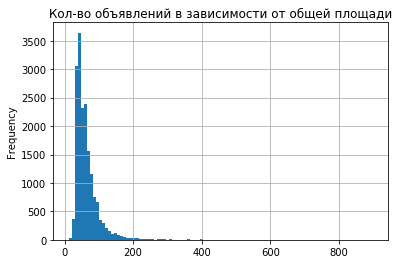

In [52]:
print(round(data['total_area'].describe()))
data['total_area'].plot(kind='hist', bins=100, title='Кол-во объявлений в зависимости от общей площади', grid=True);

Площадь квартиры более 200 квадратных метров — уже редкость. Больше 300 метров почти не встречаются. А на участке более 400 секунд гистограмма сливается с нулём (это не значит, что там ровно 0, но таких квартир единицы). Проверю:

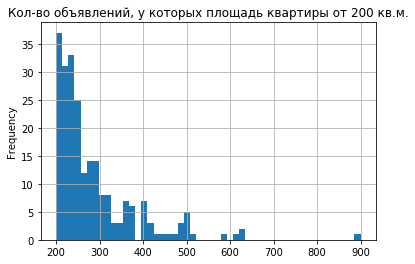

In [53]:
data['total_area'].plot(kind='hist', bins=50, range=(200, 900), grid=True, title='Кол-во объявлений, у которых площадь квартиры от 200 кв.м.');

Принимаю верхнюю границу в 400 квадратных метров. Это число кажется разумным: такие огромные квартиры встречаются редко. Если отбросить значения больше 400, много данных не потеряется.
Исключу редкие значения из датафрейма и продолжу работать с объявлениями, площадь квартир у которых не превышает 400 кв.м., а именно, удовлетворяющими условию: `data.query('total_area < 400'`). Перестрою гистограмму и построю диаграмму размаха для полученной выборки:

count    17626.0
mean        63.0
std         35.0
min         12.0
25%         41.0
50%         54.0
75%         73.0
max        399.0
Name: total_area, dtype: float64


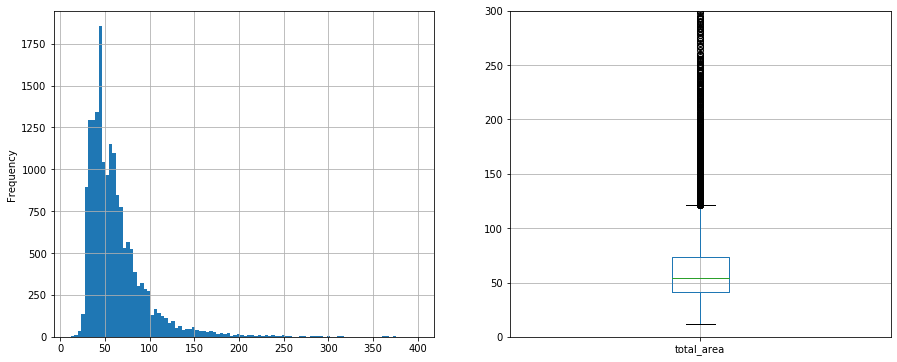

In [54]:
data = data.query('total_area < 400')
data = data.reset_index(drop=True)

print(round(data['total_area'].describe()))

fig, axes = plt.subplots(1,2,figsize=(15,6))
data['total_area'].plot(kind='hist', bins=100, grid=True, ax=axes[0])
data.boxplot(('total_area'), ax=axes[1])
plt.ylim(0, 300);

Рассмотрим полученные графики:

* по гистограмме видно, что значения площади квартир в данных соответствуют действительности, т.к. распределение близко к распределению Пуассона (площадь квартиры отрицательной быть не может).

* по данным полученного 'ящика с усами' можно увидеть, что нижний «ус» близок к 0, но 0 не равен, т.к. площадь квартиры нулевой быть не может - это верно. Верхний заканчивается около 120 квадратных метров. Это значение - есть ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросами. Более высокие значения рисуются отдельными точками и сливаются в единую жирную линию: значит таких выбросов даже после отсечения аномально высоких значений осталось очень много. И всё же значения, которые отсёк верхний «ус», — редкие. Видно, насколько медиана (зелёная линия - около 55 квадратных метров) не стремится к длинному хвосту высоких значений.

#### Жилая площадь (дополнительно)

count    17626.0
mean        36.0
std         22.0
min          2.0
25%         19.0
50%         31.0
75%         44.0
max        264.0
Name: living_area, dtype: float64


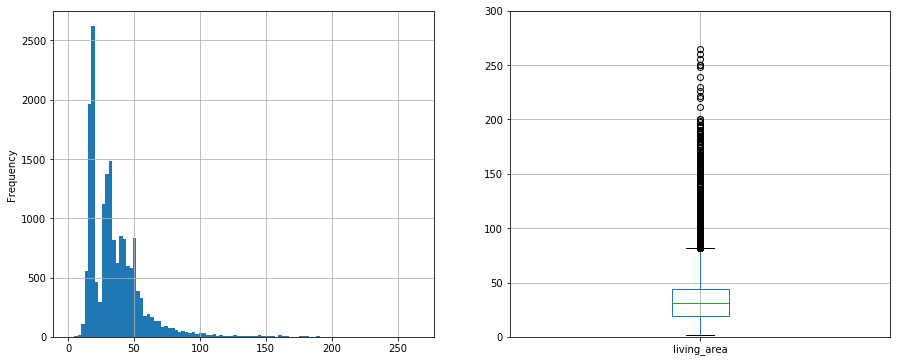

In [55]:
print(round(data['living_area'].describe()))

fig, axes = plt.subplots(1,2,figsize=(15,6))
data['living_area'].plot(kind='hist', bins=100, grid=True, ax=axes[0])
data.boxplot(('living_area'), ax=axes[1])
plt.ylim(0, 300);

Здесь прям явные перекосы в районе медианных значений по категориям (большая, квартира, очень большая, средняя и маленькая), но это логично, т.к. пропуски данных в этом столбце были заменены именно таким образом.

#### Площадь кухни (дополнительно)

count    17626.0
mean        11.0
std          6.0
min          1.0
25%          7.0
50%          9.0
75%         12.0
max        107.0
Name: kitchen_area, dtype: float64


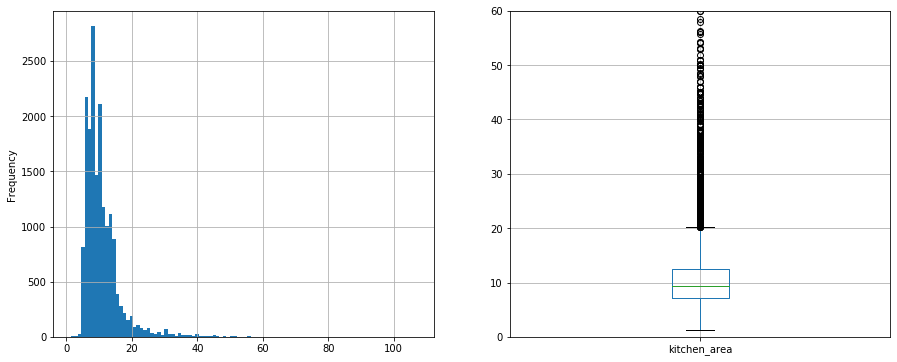

In [56]:
print(round(data['kitchen_area'].describe()))

fig, axes = plt.subplots(1,2,figsize=(15,6))
data['kitchen_area'].plot(kind='hist', bins=100, grid=True, ax=axes[0])
data.boxplot(('kitchen_area'), ax=axes[1])
plt.ylim(0, 60);

ВВ данном случаетакая же ситуация, что и с жилой площадью - в районе медианных значений по категориям (большая, квартира, очень большая, средняя и маленькая) - наблюдаются пики, пропуски данных в этом столбце также были заменены медианами.

#### Цена

count        17626.0
mean       7505784.0
std        9208052.0
min          12190.0
25%        4050000.0
50%        5300000.0
75%        7800000.0
max      330000000.0
Name: last_price, dtype: float64


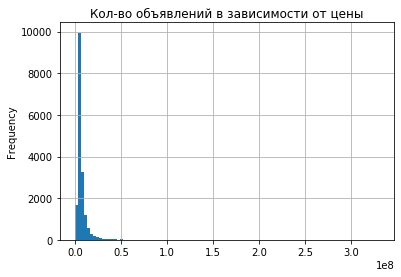

In [57]:
print(round(data['last_price'].describe()))
data['last_price'].plot(kind='hist', bins=100, title='Кол-во объявлений в зависимости от цены', grid=True);

Здесь явно что-то не в порядке, ожидаемое распределение цены - это гистограмма с длинными хвостами вокруг среднего, т.к. Санкт-Петербург и область - по идее обычный город с обычными людьми, где есть и дорогая недвижимость и дешевая, ожидала нормальное распределение с пиком около 8 млн (наверное, так оно и есть по таблице `describe`), но яркий выброс около нуля и шкала абсции до 330 млн - это непорядок. 
Также настораживает значение стандартного отклонения в 9 млн, огромное значение, значит, в наборе данных втречаются серьёзные аномалии или выбросы.
Нужно разбираться.

Перестрою гистограмму, ограничив шкалу абсцисс значением в 50 миллионов рублей за квартиру и построю диаграмму размаха для столбца `last_price`, ограничив диапазон по вертикали значениями, получаенными методом подбора, чтобы график был информативен - (-1000000, 15000000): 

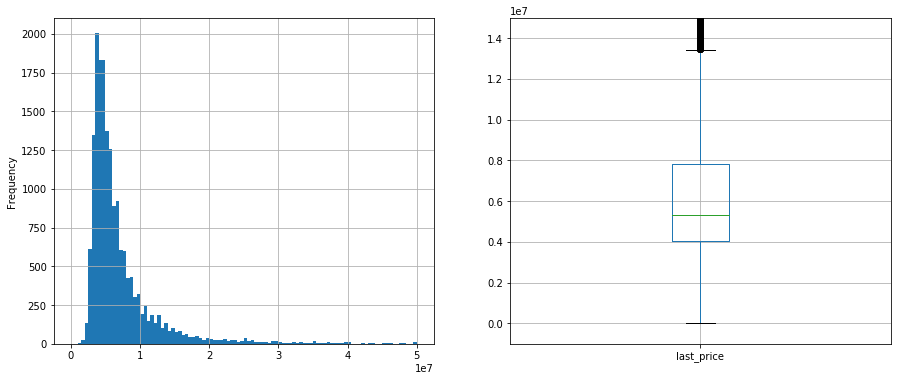

In [58]:
fig, axes = plt.subplots(1,2,figsize=(15,6))
data['last_price'].plot(kind='hist', bins=100, range=(0, 50000000), grid=True, ax=axes[0])
data.boxplot(('last_price'), ax=axes[1])
plt.ylim(-1000000, 15000000);

Рассмотрим полученные графики:

* Ограничив значения на гистограмме получаем пуассоновское распределение, которое похоже на реальность, нормальные значения стоимости квартир до 10 миллионов и дальше - редкие объявления с ценой выше.
* по данным 'ящика с усами' можно увидеть следующее: нижний «ус» упирается в 0, это минимальное значение. Верхний заканчивается около 13 миллионов за квартиру. Это значение - есть ориентировочная граница нормального размаха. Всё, что лежит за ней, считается выбросом. Более высокие значения рисуются отдельными точками, но сливаются в единую жирную линию: значит таких выбросов очень много. И всё же значения, которые отсёк верхний «ус», — редкие. Видно, насколько медиана (зелёная линия - около 5.5 миллионов) не стремится к длинному хвосту высоких значений.

#### Число комнат

count    17626.0
mean         2.0
std          1.0
min          0.0
25%          1.0
50%          2.0
75%          3.0
max         19.0
Name: rooms, dtype: float64


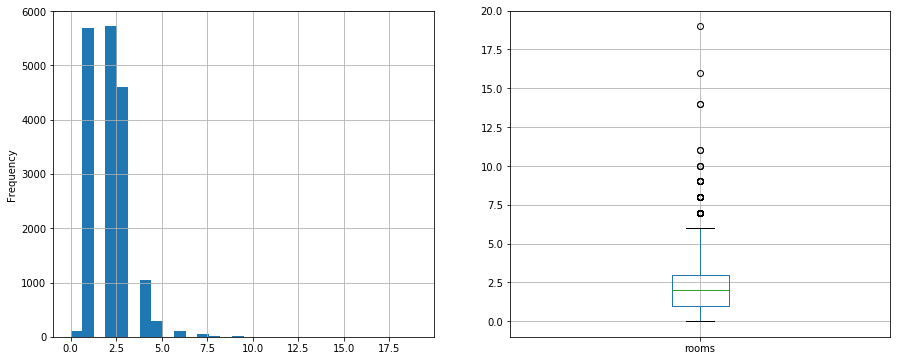

In [59]:
#runs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
print(round(data['rooms'].describe()))

fig, axes = plt.subplots(1,2,figsize=(15,6))
data['rooms'].plot(kind='hist', bins=30, grid=True, ax=axes[0])
data.boxplot(('rooms'), ax=axes[1])
plt.ylim(-1, 20);
#plt.xticks(runs) # хотела убрать ДОЛИ по шкале абсцисс, ну да ладно :)

Ясно и логично, единичные выбросы за значением более 6 комнат в квартире. Среднее значение на выборку - 2ух-комнатная квартира. Однако я заметила, что минимальное значение равно 0. Буду производить заменю нулевых значений, т.к. квартиры с нулем комнат - это ошибка. Замену буду производить медианным значением с группировкой по жилой площади. Для начала посмотрю количество строк и характер выборки по значению жилой площади, в которых значения не проставлены.

In [60]:
rooms_null = data[data['rooms'] == 0]
print('Всего квартир с нулевым значением количества комнат -', len(rooms_null))
print('Доля пропущенных значений составляет {:.1%}'.format(len(data.query('rooms == 0')) / len(data)))
print()
round(rooms_null['living_area'].describe(), 1)

Всего квартир с нулевым значением количества комнат - 114
Доля пропущенных значений составляет 0.6%



count    114.0
mean      20.3
std        8.2
min        5.0
25%       16.8
50%       18.7
75%       20.5
max       68.0
Name: living_area, dtype: float64

Из описательной таблицы видно, что минимальное значения жилой площади в выборке - 5 квадратных метров, максимальное - 68 квадратных метров. Необходимо проставить корректное значение количества комнат, где сейчас проставлены нули. Получу категории следующим образом:

In [61]:
rooms_count = [1, 2, 3, 4, 5]

for element in rooms_count:
    print('Медианное значение для', element, 'комнат -', data[data['rooms'] == element]['living_area'].median(), 'кв.м.')
    print()

Медианное значение для 1 комнат - 18.0 кв.м.

Медианное значение для 2 комнат - 31.0 кв.м.

Медианное значение для 3 комнат - 46.0 кв.м.

Медианное значение для 4 комнат - 63.5 кв.м.

Медианное значение для 5 комнат - 90.0 кв.м.



Из этих значений выберу следующие категории:
* от 5 до 24.5 кв.м. - 1 комната (31+18)/2
* от 24.5 до 38.5 - 2 комнаты (46+31)/2
* от 38.5 до 49.5 - 3 комнаты
* от 49.5 до 68 - 4 комнаты

In [62]:
#print(data[data['rooms'] == 0][['rooms', 'living_area']])
# провожу категоризацию
def category(area):
    if area['rooms'] > 0:
        return -1
    if 5 <= area['living_area'] < 24.5:
        return 1
    if 24.5 <= area['living_area'] < 38.5:
        return 2
    if 38.5 <= area['living_area'] < 49.5:
        return 3
    return 4
# записываю значения категорий в новый столбец
data['rooms_new'] = data.apply(category, axis = 1)
print(data[['rooms', 'rooms_new']].head())

# заменяю нулевые значения в исходном столбце на полученные категории
mask = data['rooms_new'] != -1
data.loc[mask, 'rooms'] = data.loc[mask, 'rooms_new']

# удаляю дополнительный столбец
data = data.drop(['rooms_new'], axis = 1)

#print(data[data['rooms'] == 0][['rooms', 'living_area']])

   rooms  rooms_new
0      3         -1
1      2         -1
2      3         -1
3      2         -1
4      1         -1


#### Высота потолков

count    17626.0
mean         3.0
std          1.0
min          1.0
25%          3.0
50%          3.0
75%          3.0
max        100.0
Name: ceiling_height, dtype: float64


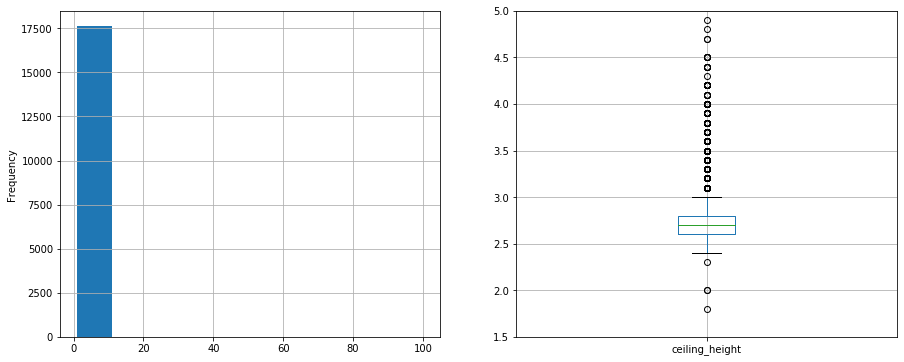

In [63]:
print(round(data['ceiling_height'].describe()))

fig, axes = plt.subplots(1,2,figsize=(15,6))
data['ceiling_height'].plot(kind='hist', bins=10, grid=True, ax=axes[0])
data.boxplot(('ceiling_height'), ax=axes[1])
plt.ylim(1.5, 5);

Тут все понятно, практически во всем Питере и его окресностях потолки примерно одной высоты. Максимальное значение равно 100, но это явная ошибка. 
Из полученной диаграммы размаха видно, что выбиваются объявления, в которых значения высоты полоков ниже 2.4 метра и выше 3 метров. Но это - единичные случаи.

### Обработка редких и выбивающихся значений

Нужно разобраться с аномалиями в выборке. 

Рассчитаю границы редких и выбивающихся значений в столбцах `total_area`, `living_area`, `kitchen_area`, `last_price`, `rooms` и `ceiling_height` и исключу эти данные из датафрейма:

In [64]:
delete_values = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height']

for element in delete_values:
    q1 = data[element].quantile(0.25)
    q3 = data[element].quantile(0.75)
    iqr = q3 - q1
    print('Исследуемый параметр -', element)
    print('Нижняя граница наиболее вероятных значений параметра -', round(q1 - 1.5 * iqr))
    print('Верхняя граница наиболее вероятных значений параметра -', round(q3 + 1.5 * iqr))
    print('Количество исключаемых строк - ', len(data[(data[element] < q1 - 1.5 * iqr) | (data[element] > q3 + 1.5 * iqr)]))
    data = data[(data[element] >= q1 - 1.5 * iqr) & (data[element] <= q3 + 1.5 * iqr)]
    data = data.reset_index(drop=True)
    print()

Исследуемый параметр - total_area
Нижняя граница наиболее вероятных значений параметра - -7
Верхняя граница наиболее вероятных значений параметра - 121
Количество исключаемых строк -  979

Исследуемый параметр - living_area
Нижняя граница наиболее вероятных значений параметра - -16
Верхняя граница наиболее вероятных значений параметра - 77
Количество исключаемых строк -  96

Исследуемый параметр - kitchen_area
Нижняя граница наиболее вероятных значений параметра - 0
Верхняя граница наиболее вероятных значений параметра - 20
Количество исключаемых строк -  636

Исследуемый параметр - last_price
Нижняя граница наиболее вероятных значений параметра - -474832
Верхняя граница наиболее вероятных значений параметра - 11324900
Количество исключаемых строк -  913

Исследуемый параметр - rooms
Нижняя граница наиболее вероятных значений параметра - -2
Верхняя граница наиболее вероятных значений параметра - 6
Количество исключаемых строк -  0

Исследуемый параметр - ceiling_height
Нижняя граница н

### Изучение времени продажи квартиры

Буду изучать время продажи квартиры. Построю гистограмму.

count    14290.0
mean       159.0
std        197.0
min          1.0
25%         45.0
50%         96.0
75%        186.0
max       1553.0
Name: days_exposition, dtype: float64


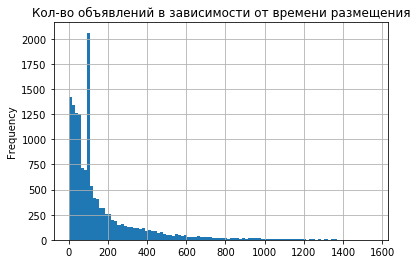

In [65]:
print(round(data['days_exposition'].describe()))
data['days_exposition'].plot(kind='hist', bins=100, title='Кол-во объявлений в зависимости от времени размещения', grid=True);

Из гистограммы ясно виден выброс на уровне примерно 100 дней, присутствует явная проблема в данных, настораживает и то, что стандартное отклонение (`std`) очень велико, которое говорит о том, что в наборе данных встречаются серьёзные аномалии или выбросы.

In [66]:
data['days_exposition'].value_counts().head(10)

96    1568
60     422
45     385
7      162
30     157
3      116
4      113
14     111
5      106
8      102
Name: days_exposition, dtype: int64

В разделе 2.2.7 я заменила пропущенные значения в данном столбце медианой по всем записям, скорее всего это и послужило причиной выброса. 96 дней размещения объявления встречается аж 1568 раз - это на порядок больше, чем следующее по частоте встречающееся значение. Проверю свою гипотезу: посчитаю медиану:

In [67]:
print(data['days_exposition'].median())

96.0


Гипотеза подтверждена, данный выброс - это последствие замены пропущенных значений на общую медиану.
Построю диаграмму размаха, чтобы определить, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго.


q1 = 45
q3 = 186

Нижняя граница наиболее вероятных значений параметра - -166
Верхняя граница наиболее вероятных значений параметра - 398


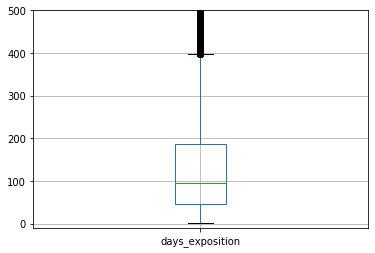

In [68]:
data.boxplot('days_exposition')
plt.ylim(-10, 500);
q1 = data['days_exposition'].quantile(0.25)
q3 = data['days_exposition'].quantile(0.75)
iqr = q3 - q1
print()
print('q1 =', round(q1))
print('q3 =', round(q3))
print()
print('Нижняя граница наиболее вероятных значений параметра -', round(q1 - 1.5 * iqr))
print('Верхняя граница наиболее вероятных значений параметра -', round(q3 + 1.5 * iqr))

По диаграмме размаха, а также из таблицы `describe()` можно увидеть, что обычно продажа квартиры происходит по истечении 96 дней после размещения объявления - в среднем квартира продается в течение 3 месяцев. Обычно, период времени, за который реализуются квартиры, составляет от полутора месяцев до полугода, в этом промежутке сосредоточено больше всего объявлений. Если продажа занимает больше 186 дней - то это уже считается долгой продажей, если удалось продать квартиру менее, чем за 45 дней - это считается быстрой продажей. Если квартира не продается по истечении 398 дней и более - это уже аномалии, нужно проанализировать, соответствует ли выставленная цена реальности.

### Центральная зона. Анализ факторов, влияющих на стоимость жилья

В этом разделе я попытаюсь выяснить, какая область входит в центр. Создаю столбец с расстоянием до центра в километрах: округляю до целых значений. После этого считаю среднюю цену для каждого километра. Для этого необходимо сгруппировать выборку по удаленности от центра и посчитать среднюю цену за квадратный метр площади. Построю график.

*Т.к. предстоит построить множество похожих графиков, напишу нексколько функций, которые автоматизируют построение гистограмм и диаграмм размаха, а также расчет коэффициентов корреляции и комментариев к ним:*

In [69]:
def grafics(dataframe, parameter):
    fig, axes = plt.subplots(1,2,figsize=(15,6))
    dataframe.boxplot(column='meter_price', by=parameter, ax=axes[0])
    dataframe.boxplot(column='last_price', by=parameter, ax=axes[1]);
    
def correlation(dataframe, parameter):
    print('Коэффициенты корреляции:')
    print('Цена за кв.м. - ', round(dataframe['meter_price'].corr(dataframe[parameter]), 2))
    print('Общая стоимость - ', round(dataframe['last_price'].corr(dataframe[parameter]), 2))

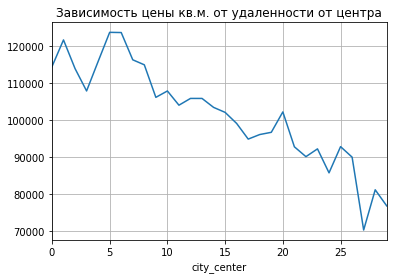

In [70]:
sp_data = data.query('locality_name == "Санкт-Петербург"')
sp_data['city_center'] = (sp_data['city_centers_nearest'] / 1000).round().astype(int)

sp_data.groupby('city_center')['meter_price'].mean().plot(x='city_centers_nearest', y='meter_price', title='Зависимость цены кв.м. от удаленности от центра', grid=True);

Из полученного графика ясно видно что цена недвижимости в Санкт-Петербурге прямо пропорциональна удаленности кватриры от центра города. Чем ближе к центру - тем дороже. На удалении около 5 километров характер графика меняется на явно нисходящий тренд. поэтому я делаю вывод, что центральная зона - это окружность радиусом 5 километров от центра города.

Проведу категоризацию данных по удаленности от центра города. Как было выяснено, центральная зона - это 5-метровый радиус от центра, близко к центру будем считать расстояние до 20 км, дальше график сильно обрывается вниз, поэтому обозначу категорию дальше 20км - далеко от центра.

In [71]:
data['city_centers_nearest'] = round((data['city_centers_nearest']), 2)

def categorize(row_values):
    if 0 < row_values['city_centers_nearest'] <= 5000:
        return 'центр'
    if 5000 < row_values['city_centers_nearest'] <= 20000:
        return 'близко к центру'
    return 'далеко от центра' 

data['center_category'] = data.apply(categorize, axis = 1)
print(data[['city_centers_nearest', 'center_category']].head(10))

   city_centers_nearest   center_category
0               13933.0   близко к центру
1               19143.0   близко к центру
2               11634.0   близко к центру
3               15008.0   близко к центру
4               13878.0   близко к центру
5               51677.0  далеко от центра
6               33058.0  далеко от центра
7               30759.0  далеко от центра
8               14259.0   близко к центру
9               10698.0   близко к центру


В следующем разделе я выделю сегмент квартир в центре и в этом сегменте изучу следующие параметры: площадь, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления. Чтобы ответить на вопросы , какие факторы более всего влияют на цену недвижимости.

#### Общая площадь

Влияет ли площадь квартиры на цену ее квадратного метра или ее стоимость в центральном районе Санкт-Петербурга?

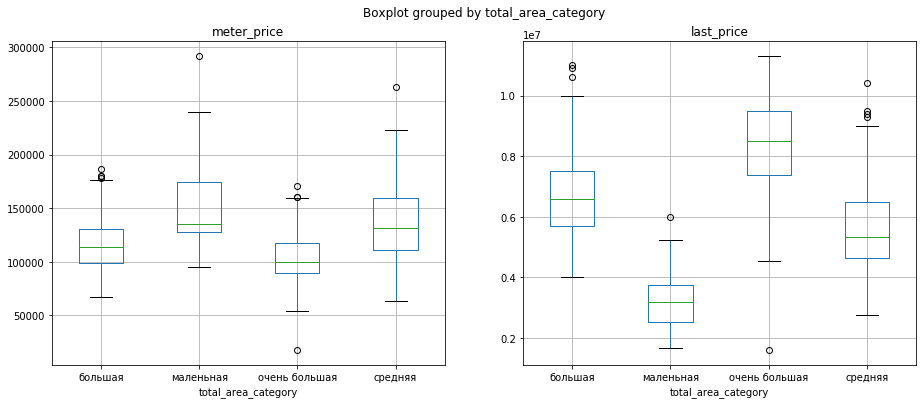

In [72]:
city_center = data.query('city_centers_nearest <= 5000')
grafics(city_center, 'total_area_category')

Дополнительно рассчитаю коэффициенты корреляции для параметров `total_area` и `meter_price`/`last_price`, чтобы сделать окончательный вывод:

In [73]:
correlation(city_center, 'total_area')

Коэффициенты корреляции:
Цена за кв.м. -  -0.56
Общая стоимость -  0.69


Проанализировав полученные графики и подкрепив их коэффициентами корреляции, можно сделать вывод о том, что наблюдается обратная пропорциональность между размером квартиры и ценой за ее квадратный метр, т.е. чем больше квартира, тем ниже цена за ее метр (коэффициент корреляции отрицателен и стремится к единице).

Однако что касается общей стоимости квартиры, то здесь наоборот - явная прямая зависимость общей стоимости жилья от площади квартиры (коэффициент корреляции положителен и также стремится к единице). Чем больше квартира - тем она дороже.

Также можно утверждать, что зависимость общей стоимости жилья в центральном районе Санки-Петербурга от его площади более сильная, чем зависимость цены за метр от площади квартиры, т.к. коэффициеет корреляции между общей стоимостью и площадью по модулю ближе к единице. Это же можно увидеть и на диаграммах размаха.

#### Число комнат

Влияет ли количество комнат в квартире на цену ее квадратного метра или ее стоимость в центральном районе Санкт-Петербурга?

In [74]:
city_center['city_centers_nearest'].describe()

count     775.000000
mean     3590.326452
std      1134.580029
min       399.000000
25%      3001.500000
50%      3896.000000
75%      4487.000000
max      4996.000000
Name: city_centers_nearest, dtype: float64

Коэффициенты корреляции:
Цена за кв.м. -  -0.53
Общая стоимость -  0.5


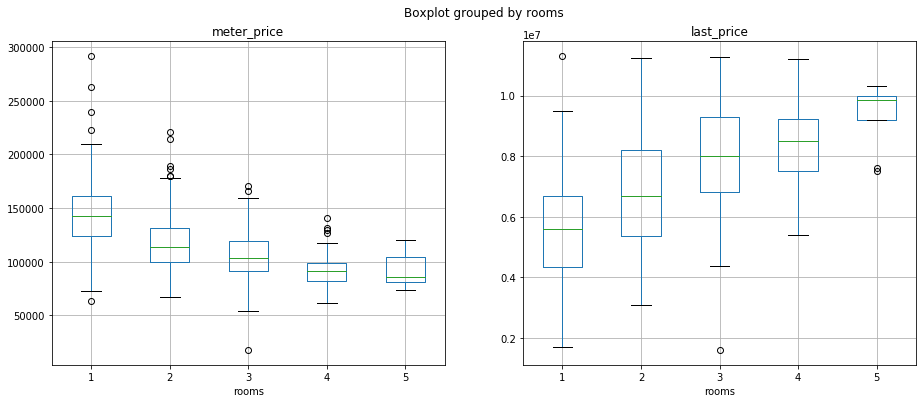

In [75]:
grafics(city_center, 'rooms')
correlation(city_center, 'rooms')

Прослеживается явная обратная зависимость цены квадратного метра квартир в центральном районе Санкт-Петербурга от количества комнат. Чем комнат в квартире больше, тем ниже цена за ее квадратный метр. Что касается общей стоимости квартиры, то здесь все наоборот - прямая зависимость, т.е. чем больше комнат, тем дороже квартира, что логично.

#### Высота потолков

Влияет ли высота потолка в квартире на цену ее квадратного метра или ее стоимость в центральном районе Санкт-Петербурга?

Коэффициенты корреляции:
Цена за кв.м. -  -0.19
Общая стоимость -  0.06


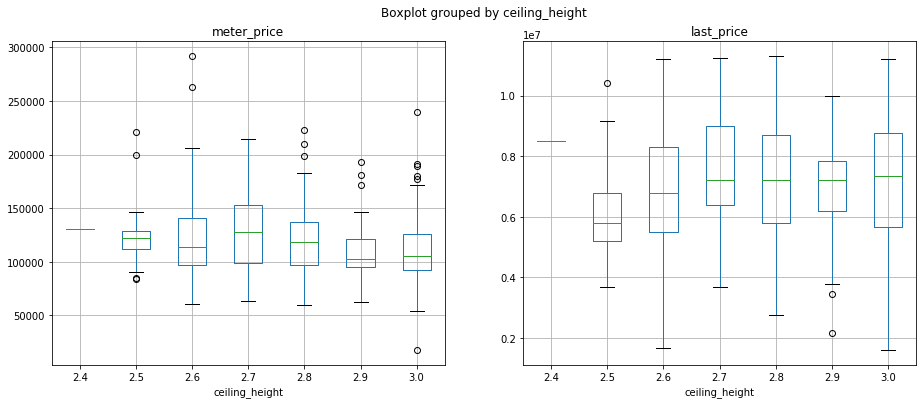

In [76]:
grafics(city_center, 'ceiling_height')
correlation(city_center, 'ceiling_height')

Исходя из значений коэффициентов корреляции, высота потолков квартир в центральном районе Санкт-Петербурга не сильно влияет ни на стоимость жилья в целом, ни на цену за его квадратного метра. Что подтверждают диаграммы размаха. Медианы  для каждого значения высоты потолка находятся примерно на одном и том же уровне цены.

#### Этаж

Влияет ли этаж, на котором расположена квартира, на цену ее квадратного метра или ее стоимость в центральном районе Санкт-Петербурга?

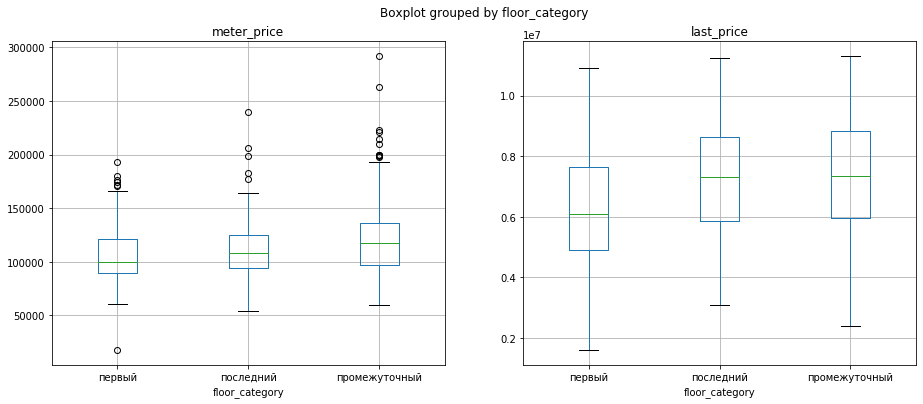

In [77]:
grafics(city_center, 'floor_category')

Из диаграмм видно, что цена за квадратный метр квартир на промежуточных этажах в центральном районе Санкт-Петербурга выше, чем на первых и последних этажах. Самые дешевые квадратные метры и самые доступные квартиры расположены на первых этажах. Однако общая стоимость жилья на последних этажах не сильно отличается от квартир на промежуточных этажах.

#### Удаленность от центра города

Влияет ли удаленность от центра на цену квадратного метра или стоимость квартиры в центральном районе Санкт-Петербурга?

Здесь для построения диаграммы размаха необходимо пперевести удаленность от центра в километры и посмотреть значения на удалении каждого километра. Создам дополнительный столбец, куда помещу значения удаленности от центра в километрах:

In [78]:
city_center['center_km'] = round(city_center['city_centers_nearest'] / 1000)
print(city_center[['city_centers_nearest', 'center_km']].head())

     city_centers_nearest  center_km
60                 2818.0        3.0
84                 2913.0        3.0
96                 4937.0        5.0
105                3301.0        3.0
123                1645.0        2.0


Теперь построю диаграммы размаха для значения цены квадратного километра и для общей стоимости квартир:

Коэффициенты корреляции:
Цена за кв.м. -  0.07
Общая стоимость -  -0.04


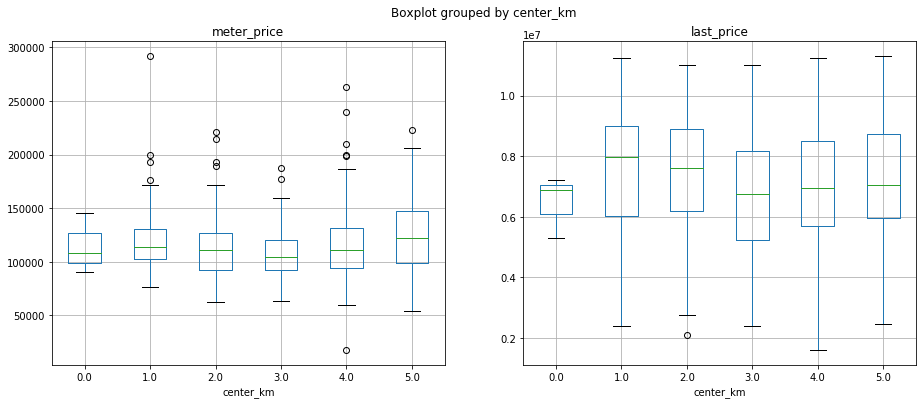

In [79]:
grafics(city_center, 'center_km')
correlation(city_center, 'city_centers_nearest')

Проанализировав полученные графики и подкрепив их коэффициентами корреляции, можно сделать вывод о том, что для цены квартиры в центральном районе Санкт-Петербурга не имеет значения ее удаленность от самого центра, т.к. цена остается неизменной (что видно из диаграмм размаха), а также значения коэффициентов корреляции стремятся к нулю, что еще раз это подтвержает.

#### Дата размещения

Влияет ли дата размещения объявления на цену квадратного метра квартиры или ее стоимость в центральном районе Санкт-Петербурга?

Коэффициенты корреляции:
Цена за кв.м. -  0.05
Общая стоимость -  -0.01


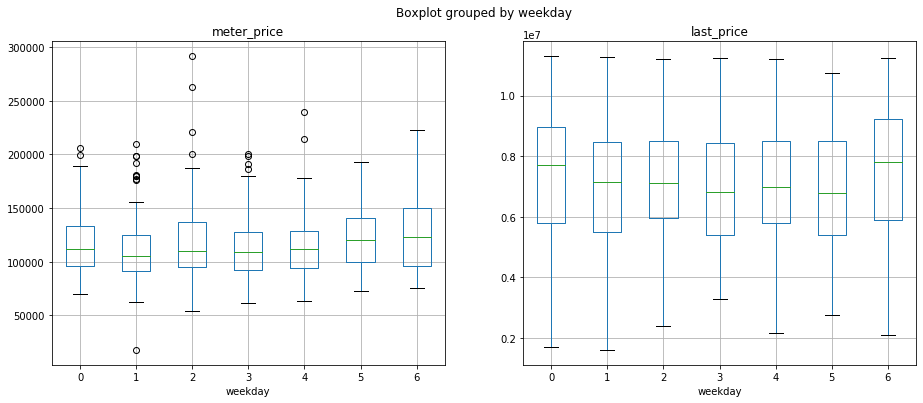

In [80]:
grafics(city_center, 'weekday')
correlation(city_center, 'weekday')

Коэффициенты корреляции:
Цена за кв.м. -  -0.04
Общая стоимость -  -0.08


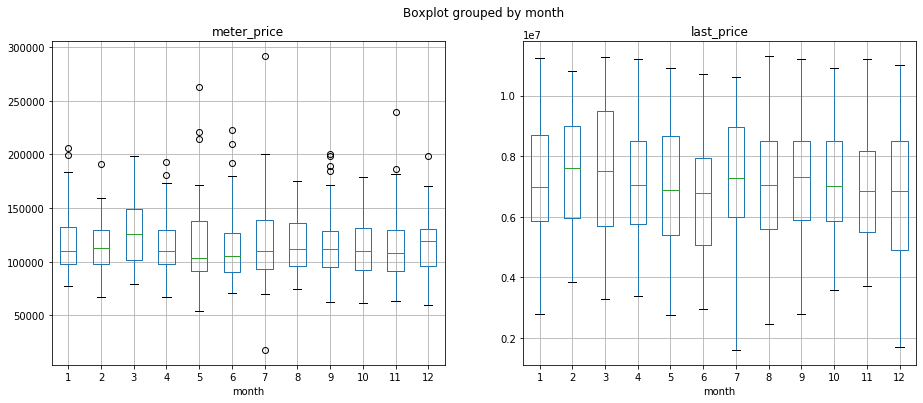

In [81]:
grafics(city_center, 'month')
correlation(city_center, 'month')

Коэффициенты корреляции:
Цена за кв.м. -  0.16
Общая стоимость -  0.03


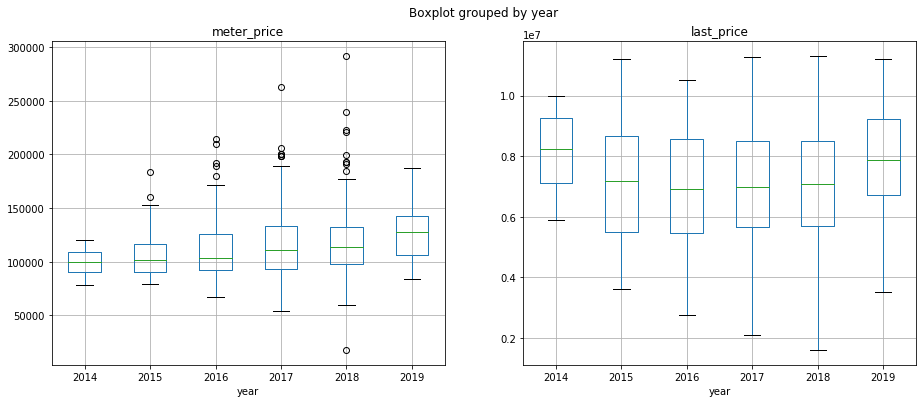

In [82]:
grafics(city_center, 'year')
correlation(city_center, 'year')

Проанализировав полученные графики и подкрепив их коэффициентами корреляции, однозначено можно сделать вывод о том, что для цены квартиры в центральном районе Санкт-Петербурга не имеет значения дата размещения объявления, ни день недели, ни месяц размещения, ни год, т.к. цена остается неизменной (что видно из диаграмм размаха), а также значения коэффициентов корреляции стремятся к нулю, что еще раз это подтвержает.

### Все районы. Изучение факторов, влияющих на стоимость жилья

В этом разделе я буду анализировать, какие факторы больше всего влияют на цену за квадратный метр и на общую стоимость квартир. Рассматриваемые параметры:
* площадь;
* число комнат;
* этаж (первый или последний);
* удалённость от центра;
* дата размещения (день недели, месяц и год). 

#### Общая площадь

Коэффициенты корреляции:
Цена за кв.м. -  -0.21
Общая стоимость -  0.77


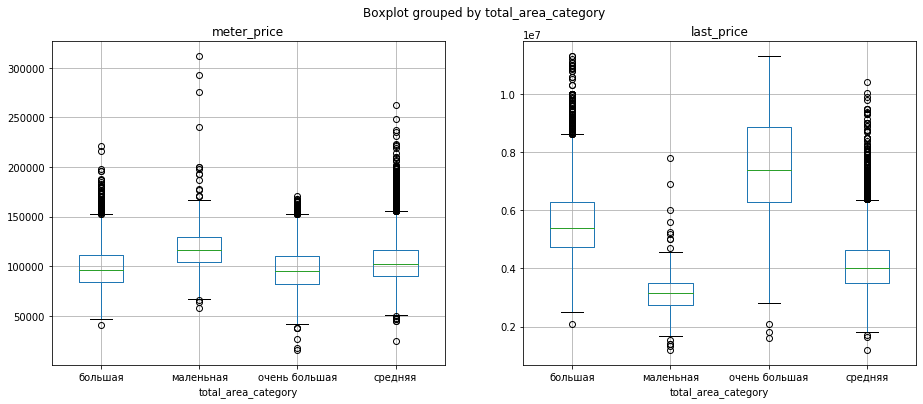

In [83]:
grafics(data, 'total_area_category')
correlation(data, 'total_area')

Из диаграмм размаха и на основании коэффициентов корреляции видно - медиана находится примерно на одном уровне, что означает - цена квадратного метра примерно одинакова и не изменяется в зависимости от площади квартиры, также коэффициент корреляции близок к нулю, что это подтверждает.

Однако, что касается общей стоимости квартиры, то здесь обнаружена прямая зависимость: чем больше площадь квартиры - тем выше цена.

#### Число комнат

Коэффициенты корреляции:
Цена за кв.м. -  -0.36
Общая стоимость -  0.5


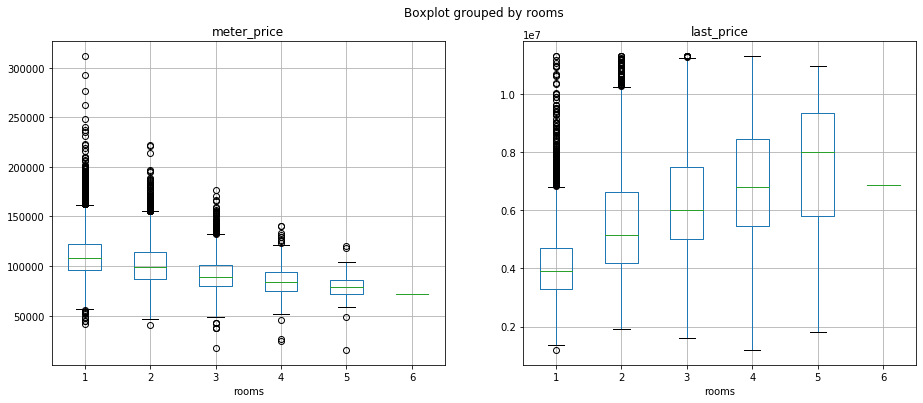

In [84]:
grafics(data, 'rooms')
correlation(data, 'rooms')

Из диаграммы размаха прослеживается обратная зависимость цены квадратного метра от количества комнат. Чем комнат в квартире больше, тем ниже цена за ее квадратный метр, но коэффициент корреляции не очень большой, поэтому зависимость слабая. Что касается общей стоимости квартиры, то здесь наоборот - явная прямая зависимость, т.е. чем больше комнат, тем дороже квартира.

Выбиваются только 6-комнатные квартиры, которые стоят как 4-комнатные, но скорее всего это ошибка или слишком маленькая выборка (что вероятнее), проверю свое предположение:

In [85]:
display(data.query('rooms == 6'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name_new,total_area_category,meter_price,weekday,month,year,floor_category,living_part,kitchen_part,center_category
8730,3,6864000,95.0,2018-10-12,6,2.5,15,75.0,3,False,...,Санкт-Петербург,очень большая,72252.6,4,10,2018,промежуточный,0.79,0.14,близко к центру


Нет, не ошибка, просто 6-комнатная квартира в выборке представлена всего одна, и среднее - и есть цена этой квартиры - она соизмерима со средней ценой на четырехкомнатные квартиры. Это единичный случай.

#### Высота потолков

Коэффициенты корреляции:
Цена за кв.м. -  0.22
Общая стоимость -  0.32


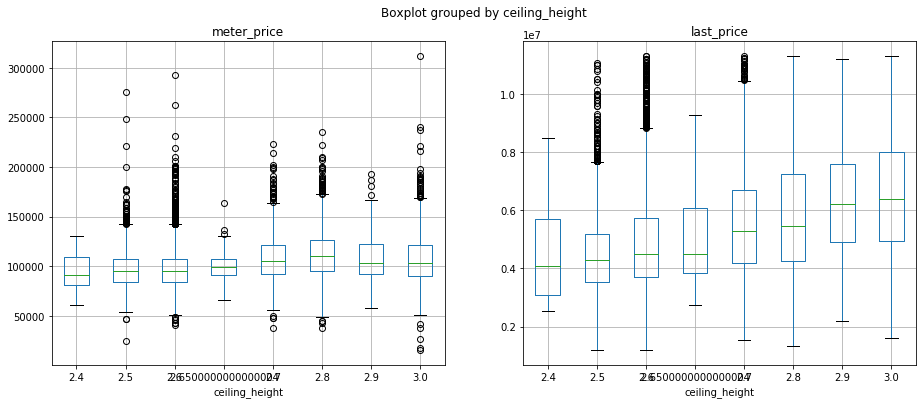

In [86]:
grafics(data, 'ceiling_height')
correlation(data, 'ceiling_height')

Как ни странно, но чем выше потолок, тем выше стоимость квартиры, но зависимотсь очень слабая. Квартиры с трехметровыми потолками стоят чуть дороже, а самые дешевые квартиры - это те, у которых высота потолков составляет 2.4 метра. 

Однако квадратные метры дороже стоят у тех квартир, у которых высота потолков равна 2.8, это может быть связано с близостью относительно центра города или с какими-либо другими факторами, в принципе, коэффициент корреляции слишком мал, чтобы говорить о зависимости этих параметров.

#### Этаж

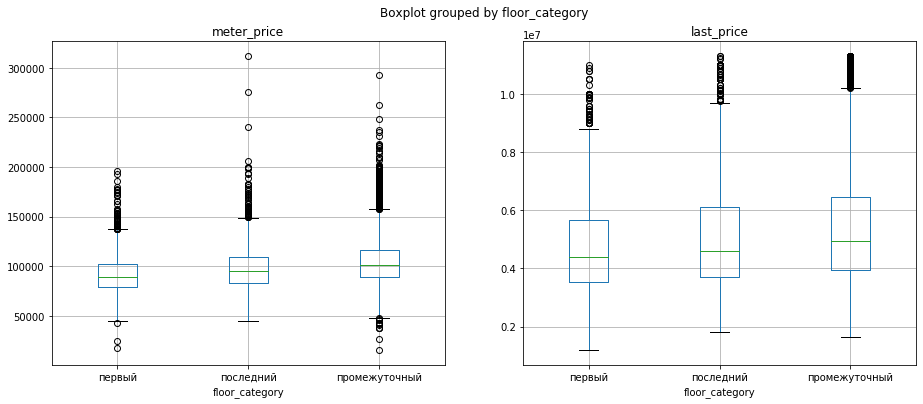

In [87]:
grafics(data, 'floor_category')

Из диаграмм видно, что цена за квадратный метр квартир на промежуточных этажах и их общая стоимость выше, чем на первых и последних этажах. Самые дешевые квадратные метры и самые доступные квартиры расположены на первых этажах.

#### Удаленность от центра города

Коэффициенты корреляции:
Цена за кв.м. -  -0.37
Общая стоимость -  -0.3


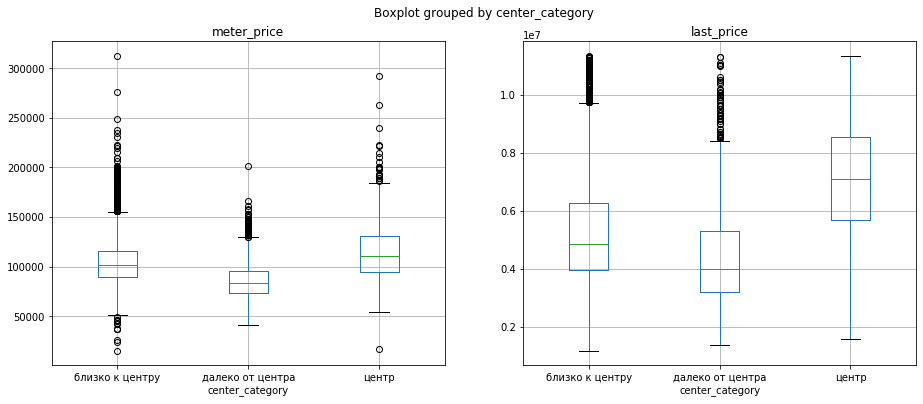

In [88]:
grafics(data, 'center_category')
correlation(data, 'city_centers_nearest')

Тут тоже все логично - чем ближе к центру, тем дороже квадратные метры, тем дороже сама квартира. Однако, зависимость слабая, т.к. коэффициенты корреляции не стремятся к единице.

#### Дата размещения

Буду проверять 3 параметра даты размещения объявления о продаже недвижимости: день недели, месяц и год. Есть ли зависимость цены за квадратный метр от этих значений.

Коэффициенты корреляции:
Цена за кв.м. -  0.0
Общая стоимость -  -0.0


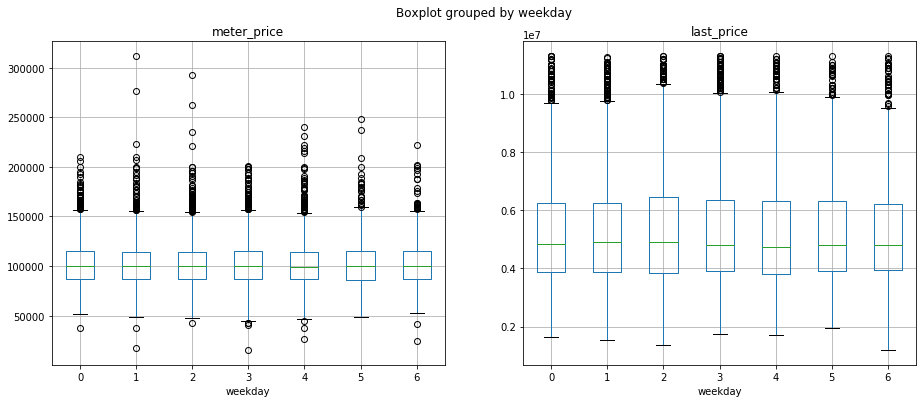

In [89]:
grafics(data, 'weekday')
correlation(data, 'weekday')

Коэффициенты корреляции:
Цена за кв.м. -  -0.01
Общая стоимость -  -0.01


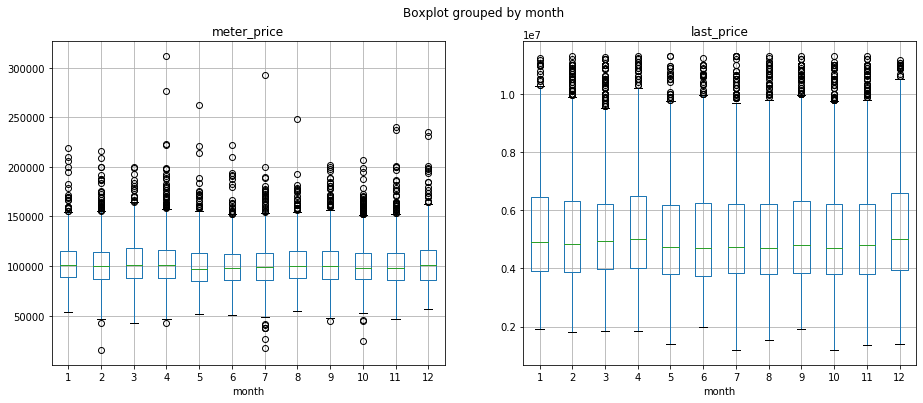

In [90]:
grafics(data, 'month')
correlation(data, 'month')

Коэффициенты корреляции:
Цена за кв.м. -  0.15
Общая стоимость -  0.04


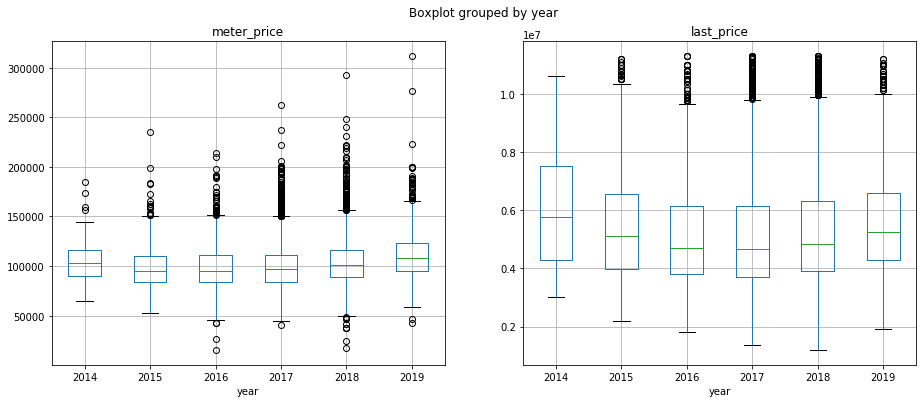

In [91]:
grafics(data, 'year')
correlation(data, 'year')

Из полученных диаграмм можно сделать следующие выводы:
* день недели размещения объявления не влияет на общую стоимость квартир и цену за метр;
* разброс по месяцам тоже не сильно отличается - в пределах погрешности, скорее небольшой разброс по временам года;
* до 2016 года цена на квартиры падали, однако с 2016 года наметилась очень слабая тенденция к повышению цен на жилье.

### Поиск населённых пунктов с самой высокой и низкой стоимостью жилья

В этом разделе я буду выделять населенные пункты с самой высокой и самой низкой стоимостью жилья. Для начала я выберу 10 населённых пунктов с наибольшим числом объявлений. Сформирую список из этих населенных пунктов и посчитаю для них среднюю цену квадратного метра.

In [92]:
#print(data.groupby(by='locality_name')['locality_name'].count().sort_values(ascending=False).head(10))
city_top = ['Санкт-Петербург', 'Парголово', 'Колпино', 'Пушкин', 'Петергоф', 'Красное Село', 'Сестрорецк', 'Ломоносов', 'Кронштадт', 'Стрельна']
#print(data.groupby(by='locality_name')['meter_price'].mean())
for element in city_top:
    print(element)
    print('Средняя цена квадратного метра -', data.loc[data['locality_name'] == element]['meter_price'].mean().round())
    print()

Санкт-Петербург
Средняя цена квадратного метра - 104728.0

Парголово
Средняя цена квадратного метра - 90185.0

Колпино
Средняя цена квадратного метра - 75278.0

Пушкин
Средняя цена квадратного метра - 99832.0

Петергоф
Средняя цена квадратного метра - 83500.0

Красное Село
Средняя цена квадратного метра - 71978.0

Сестрорецк
Средняя цена квадратного метра - 100063.0

Ломоносов
Средняя цена квадратного метра - 73138.0

Кронштадт
Средняя цена квадратного метра - 79823.0

Стрельна
Средняя цена квадратного метра - 88364.0



Далее найду населённые пункты с самой высокой и низкой средней стоимостью жилья, а также населенные пункты, в которых находятся самые дешевые и самые дорогие объекты в данной выборке.

In [93]:
print('Населённые пункты с самой высокой средней стоимостью жилья (в млн.р.):')
print(data.groupby(by='locality_name')['last_price'].mean().sort_values(ascending=False).head(5) / 1000000)
print()
print('Населённые пункты с самой низкой средней стоимостью жилья (в млн.р.):')
print(data.groupby(by='locality_name')['last_price'].mean().sort_values(ascending=True).head(5) / 1000000)
print()
print('Топ населённых пунктов, в которых расположены самые дорогие объекты (в млн.р.):')
print(data.groupby(by='locality_name')['last_price'].max().sort_values(ascending=False).head(5) / 1000000)
print()
print('Топ населённых пунктов, в которых расположены самые дешевые объекты недвижимости (в млн.р.):')
print(data.groupby(by='locality_name')['last_price'].min().sort_values(ascending=True).head(5) / 1000000)

Населённые пункты с самой высокой средней стоимостью жилья (в млн.р.):
locality_name
Сестрорецк         5.494514
Санкт-Петербург    5.405393
Пушкин             5.172228
Зеленогорск        4.814648
Парголово          4.454467
Name: last_price, dtype: float64

Населённые пункты с самой низкой средней стоимостью жилья (в млн.р.):
locality_name
Ломоносов       3.552405
Красное Село    3.614682
Кронштадт       3.739845
Колпино         3.745138
Петергоф        4.033168
Name: last_price, dtype: float64

Топ населённых пунктов, в которых расположены самые дорогие объекты (в млн.р.):
locality_name
Санкт-Петербург    11.320
Сестрорецк         11.300
Павловск           11.300
Петергоф           11.100
Зеленогорск        10.965
Name: last_price, dtype: float64

Топ населённых пунктов, в которых расположены самые дешевые объекты недвижимости (в млн.р.):
locality_name
Санкт-Петербург    1.190
Парголово          1.400
Ломоносов          1.650
Красное Село       1.799
Пушкин             1.990
Name: la

### Выводы по разделу

В результате проделанной работы были проведены следующие мероприятия:
* изучены следующие параметры: площадь, цена, число комнат, высота потолков;
* построены гистограммы и диаграммы размаха для каждого параметра;
* на основании диаграмм удалены редкие и выбивающиеся значения;
* изучено время продажи квартиры, построены гистограммы, рассчитаны среднее и медиана;
* оценены факторы, которые больше всего влияют на стоимость квартиры, рассмотрены следующие зависимости стоимости квартиры и цены за квадратный метр от:
    - числа комнат,
    - этажа (первого или последнего),
    - высоты потолков,
    - удалённости от центра,
    - даты размещения (дня недели, месяца и года);
* определены 10 населённых пунктов с наибольшим числом объявлений, для этих населённых пунктов рассчитана средняя цена квадратного метра;
* выделены населённые пункты с самой высокой и низкой стоимостью жилья;
* определена центральная область;
* для центральной области оценены факторы, которые больше всего влияют на стоимость квартир, рассмотрены следующие зависимости стоимости квартиры и цены за квадратный метр от:
    - числа комнат,
    - этажа (первого или последнего),
    - высоты потолков,
    - удалённости от центра,
    - даты размещения (дня недели, месяца и года).

## Общие выводы

Получен файл с информацией объектах недвижимости, размещенные с 2014 по 2019 года. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.

Данные из таблицы прошли полную предобработку, включающую в себя:
   * восстановление стилей названий для колонок с нарушениями стиля;
   * определение и заполнение всех пропущенных значений, появившихся скорее всего в связи с объединением данных из нескольких БД, для которых прослежена логика заполнения возможность, пропуски заполнены в соответствии со следующей логикой;
   * удаление дубликатов в названиях населенных пунктов;
   * категоризацию данных в целях решения поставленных конкретных задач;
   * исключение строк с отсутствующими значениями, для которых восстановить данные не удалось;
   * замену типов в столбцах, где это необходимо.

Что касается технической части вопроса, то тут нужно обязательно обратить внимание на качество исходных данных. Огромное количество данных прошло корректировку в процессе предварительной предобработки. Скорее всего появление ошибок, пропусков и дубликатов связано с человеческим фактором и отсутствием формализации данных на этапе заполнения, т.е. данные вносятся пользователем вручную, а не их ниспадающих списков, также скорее всего отсутствует признак обязательности заполнения полей, с чем связано огромное количество пропущенных значений. Возможно, форма заполнения объявления о продаже недвижимости нуждается в доработке для получения более 'чистых' данных.

Изучены следующие параметры: общая площадь квартиры, жилая, площадь кухни, цена, число комнат и высота потолков. С помощью диаграмм размаха, а также описательных таблиц для каждого параметра определены средние значения, нижние и верхние границы вероятных значений исследуемых параметров. Удалены редкие и выбивающиеся значения.

Проведен подробный исследовательский анализ данных, который показал следующие результаты:

   * Обычно продажа квартиры происходит по истечении 96 дней после размещения объявления - в среднем квартира продается в течение 3 месяцев. Обычно, период времени, за который реализуются квартиры, составляет от полутора месяцев до полугода, в этом промежутке сосредоточено больше всего объявлений. Если продажа занимает больше 186 дней - то это уже считается долгой продажей, если удалось продать квартиру менее, чем за 45 дней - это считается быстрой продажей. Если квартира не продается по истечении 398 дней и более - это уже аномалии, нужно проанализировать, соответствует ли выставленная цена реальности.
   * Существует прямая зависимость между стоимостью недвижимости и ее площадью и количеством комнат, т.е. чем больше площадь квартиры (чем больше комнат) - тем выше ее цена, однако если квартира больше, то определено, что цена квадратного метра будет уменьшаться.
   * Опеределено, что квартиры с трехметровыми потолками стоят чуть дороже, чем квартиры с потолками ниже (это утверждение не относится к квартирам, расположенным в центра Санкт-Петербурга, там высота потолков на стоимость квартир не влияет).
   * Выяснено, что цена за квадратный метр квартир на промежуточных этажах и их общая стоимость выше, чем на первых и последних этажах. Самые дешевые квадратные метры и самые доступные квартиры расположены на первых этажах. Особенность квартир, расположенных именно в центре Санкт-Петербура заключается в том, что общая стоимость жилья на последних этажах не сильно отличается от стоимости квартир на промежуточных этажах, хотя во всех остальных исследуемых районах квартиры на последних этажах - дешевле.
   * Что касается удаленности от центра города, то тут ситуация следующая: для цены квартир, расположенных в центральном районе Санкт-Петербурга, не имеет никакого значения ее удаленность от самого центра, т.е. цена на них не колеблется в зависимости от расположения. Однако, рассматривая все районы, можно точно сказать, что чем квартира ближе к центру, тем она дороже, тем выше цена за ее квадратный метр.
   * Относительно даты размещения объявления: день недели абсолютно не влияет на общую стоимость квартир и цену за метр, ровно как и месяц (в пределах погрешности, скорее небольшой разброс по временам года). До 2016 года цена на квартиры падали, однако с 2016 года наметилась очень слабая тенденция к повышению цен на жилье (не касается центрального района Санкт-Петербурга, там цены на квартиры с течением времени не меняются, только лишь цена за квадратный метр чуть-чуть подросла).
   * 10 населенных пунктов, где сосредоточно большинство объявлений о продаже недвижимости - это Санкт-Петербург, Парголово, Колпино, Пушкин, Петергоф, Красное Село, Сестрорецк, Ломоносов, Кронштадт и Стрельна.
   * Самые дорогие квадратные метры в Питере. Там средняя цена за метр составляет 104728 рублей. Там же обнаружена самая дорогая и самая дешевая квартиры, 11.3 и 1.2 млн. рублей соответственно.
   * Cамая низкая средняя стоимость жилья - в Ломоносово. Она составяет 3.5 млн. рублей.